# NY Person Trip Predictor

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection
import warnings
import math
import time
warnings.filterwarnings('ignore')

In [2]:
path = "C:/Users/Seant/Desktop/aml_data" #edit this path to change to your path folder
#path = "/Users/weijilim/Downloads/csv"
#path = "/Users/jayneteo/Dropbox/SMU MITB/Term 2 2021/AML/Project/NHTS/csv" 

household = pd.read_csv("".join([path,'/hhpub.csv']))
person =  pd.read_csv("".join([path,'/perpub.csv']))
trip =  pd.read_csv("".join([path,'/trippub.csv']))



In [3]:
#define function 

def cat_col_prop(data, col):
    print(pd.concat([data[col].value_counts(),
          data[col].value_counts(normalize = True).mul(100)],axis = 1, keys = ('counts','percentage')))

    sns.countplot(data[col], order =  data[col].value_counts().index)

## Objective of Study

In [4]:
ny = household[household['HHSTATE']=="NY"]
ny = ny[ny['HHVEHCNT']>0]
ny_trip = trip[trip['HOUSEID'].isin(ny['HOUSEID'])]
nyorker = person[person['HOUSEID'].isin(ny['HOUSEID'])]

In [5]:
# HOSEHOLD match

ny_hh_trip = ny_trip[['HOUSEID','TDTRPNUM']].groupby(['HOUSEID']).count().reset_index()

hh_check = ny[['HOUSEID']].merge(ny_hh_trip, how = 'left')

hh_missing = sum(hh_check['TDTRPNUM'].isna())

print(str(hh_missing), ' out of ',str(len(set(ny['HOUSEID']))),' ny household no trips recorded at all',str(hh_missing/len(set(ny['HOUSEID']))*100),'%')

1411  out of  15636  ny household no trips recorded at all 9.024047070862114 %


In [6]:
# Person  rate in household

ny_trip_check = ny_trip[['HOUSEID','PERSONID','WHYTRP90']].groupby(['HOUSEID','PERSONID']).count().reset_index()
ny_check = nyorker.merge(ny_trip_check, how = 'left', left_on=['HOUSEID','PERSONID'],right_on=['HOUSEID','PERSONID'])

In [7]:
ny_check['WHYTRP90'][ny_check['WHYTRP90']>0] =1
ny_check['WHYTRP90'][ny_check['WHYTRP90'].isna()] =0

In [8]:
person_hitrate = sum(ny_check['WHYTRP90']==0)/ny_check.shape[0]*100

print('of', str(ny_check.shape[0]),' person info,',str(person_hitrate),'% did not provide any trip info')


of 32292  person info, 17.100210578471447 % did not provide any trip info


In [9]:
summ = ny_check[['HOUSEID','PERSONID','WHYTRP90']].groupby(['HOUSEID']).agg({'PERSONID':'sum',
                                                                     'WHYTRP90':'sum'}).reset_index().rename(columns = {'WHYTRP90':'TRIP_COUNTED',
                                                                                                                       'PERSONID':'HHSIZE'})
summ['percent_trips'] = summ['TRIP_COUNTED']/summ['HHSIZE'] * 100

print('average percent of household members surveyed: ',summ['percent_trips'].mean(),'%')

average percent of household members surveyed:  60.106623043559715 %


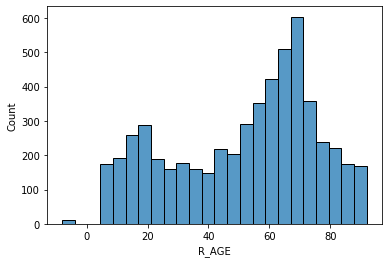

In [10]:
missing = ny_check[ny_check['WHYTRP90']==0]
sns.histplot(missing['R_AGE'])

### Goal is to create a predictive model to help predict and impute missing person trips in order to evaluate Household level trips 

## 1. Merging of Data

### 1.1. Household

In [11]:
#filtering NY Households
ny = household[household['HHSTATE'] == "NY"]

# as only studying hh with car will also filter out hh with HHVEHCNT == 0
ny = ny[ny['HHVEHCNT']>0]

In [12]:
# selection of columns based on prior background inference of potential features
ny = ny[['HOUSEID','HH_CBSA','HOMEOWN','HHSIZE','HHVEHCNT','HHFAMINC','NUMADLT','YOUNGCHILD','WRKCOUNT','MSACAT','MSASIZE','URBAN','URBANSIZE','URBRUR','LIF_CYC']]

### 1.2 Trips

In [13]:
ny_trip = trip[trip['HOUSEID'].isin(ny['HOUSEID'])]

In [14]:
# selecting trips that were done using either 3.Car, 4.SUV, 5.Van
ny_trip = ny_trip[ny_trip['TRPTRANS'].isin([3,4,5])]

In [15]:
# since only 24 lines with trip distance <= 0, removed lines
print('# of trips with dist <=0,', str(sum(ny_trip['TRPMILES']<=0)),' out of', str(len(ny_trip)))
ny_trip = ny_trip[ny_trip['TRPMILES']>0]

# of trips with dist <=0, 22  out of 87307


In [16]:
print(str(sum(ny_trip['TRVLCMIN']<=0)), ' trips missing TRVLCMIN info so will just remove since only ',str(sum(ny_trip['TRVLCMIN']<=0)/len(ny_trip)*100),"%")
ny_trip = ny_trip[ny_trip['TRVLCMIN']>0]

84  trips missing TRVLCMIN info so will just remove since only  0.09623646674686373 %


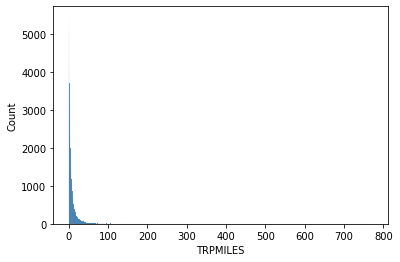

In [17]:
#Remove outlier trip miles
sns.histplot(ny_trip['TRPMILES'])
#ny_trip = ny_trip[ny_trip['TRPMILES']<40]
ny_trip = ny_trip[ny_trip['TRPMILES']<100]

In [18]:
# Summarise to Person trip counts 
ny_trip_count = ny_trip[['HOUSEID','PERSONID','TRAVDAY']].groupby(['HOUSEID','PERSONID']).agg('count').reset_index().rename(columns = {'TRAVDAY':'n_trips'})

In [19]:
ny_trip_count.head()

,HOUSEID,PERSONID,n_trips
0,30000012,1,9
1,30000082,1,5
2,30000082,2,5
3,30000380,1,3
4,30000380,2,8


In [20]:
trips_data = ny_trip[['HOUSEID','PERSONID','WHYTRP90','TRPMILES']]
trips_data['WHYTRP90'].value_counts()

# top why trips are [3,10,4,1,,8,5]

3     20107
10    17647
4     16164
1     14051
8      6467
5      5381
6      2746
11     2595
2      1257
99       22
Name: WHYTRP90, dtype: int64

In [21]:
trips_data =trips_data[trips_data['WHYTRP90'].isin([1,10,4,3,8,5])]

               counts  percentage
(-0.001, 1.0]   24049   30.130173
(2.0, 5.0]      16890   21.160906
(5.0, 11.0]     14795   18.536151
(11.0, 99.0]    14614   18.309383
(1.0, 2.0]       9469   11.863387


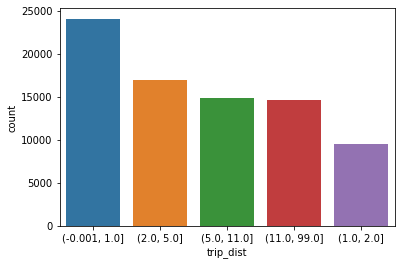

In [22]:
trips_data['round_dist']= trips_data['TRPMILES'].apply(lambda x: math.floor(x))
trips_data['trip_dist'] = pd.qcut(trips_data['round_dist'],5)
cat_col_prop(trips_data,'trip_dist')

In [23]:
trip_summary = trips_data[['HOUSEID','PERSONID','WHYTRP90','trip_dist']].groupby(['HOUSEID','PERSONID','WHYTRP90'])['trip_dist'].apply(pd.Series.mode).reset_index()
trip_summary['max_dist'] = trip_summary['trip_dist'].apply(lambda x: x.right)

In [24]:
trip_summary = trip_summary[trip_summary.groupby(['HOUSEID','PERSONID','WHYTRP90'])['max_dist'].transform(max) == trip_summary['max_dist']]

trip_summary = trip_summary[['HOUSEID','PERSONID','WHYTRP90','trip_dist']]


In [25]:
pivoted = trip_summary.pivot(index = ['HOUSEID','PERSONID'],
                  columns = 'WHYTRP90',
                  values = 'trip_dist')

trip_why_common = pd.DataFrame(pivoted.to_records()).rename(columns = {'1':'dist_to_work',
                                                       '3':'dist_to_shopping',
                                                        '4':'dist_to_family',
                                                       '5':'dist_to_school_or_church',
                                                        '8': 'dist_to_relatives',
                                                        '10':'dist_to_social'})


In [26]:
ny_trip_count = ny_trip_count.merge(trip_why_common, how = 'left',left_on = ['HOUSEID','PERSONID'],right_on = ['HOUSEID','PERSONID'])

## 1.3 People

In [27]:
# filtering people from New York
nyorker = person[person['HOUSEID'].isin(ny['HOUSEID'])]

In [28]:
# selection of columns based on prior background inference of potential features
nyorker = nyorker[['HOUSEID','PERSONID','R_AGE','EDUC','R_RACE','R_SEX','WRK_HOME','WKFTPT','OCCAT','DRIVER','TRAVDAY','OUTOFTWN']]


In [30]:
# Remove those out of town
nyorker = nyorker[nyorker['OUTOFTWN']==2]
nyorker.drop(['OUTOFTWN'],axis =1, inplace = True)

In [31]:
ny_trip_count

,HOUSEID,PERSONID,n_trips,dist_to_work,dist_to_shopping,dist_to_family,dist_to_school_or_church,dist_to_relatives,dist_to_social
0,30000012,1,9,"(5.0, 11.0]",NaN,NaN,NaN,"(11.0, 99.0]","(2.0, 5.0]"
1,30000082,1,5,"(1.0, 2.0]",NaN,"(1.0, 2.0]",NaN,NaN,"(-0.001, 1.0]"
2,30000082,2,5,NaN,"(1.0, 2.0]",NaN,NaN,NaN,"(11.0, 99.0]"
3,30000380,1,3,NaN,"(1.0, 2.0]",NaN,NaN,NaN,NaN
4,30000380,2,8,"(-0.001, 1.0]","(1.0, 2.0]",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
22054,40793808,1,2,NaN,NaN,NaN,NaN,NaN,"(2.0, 5.0]"
22055,40793808,2,9,NaN,"(2.0, 5.0]","(2.0, 5.0]",NaN,NaN,"(1.0, 2.0]"
22056,40793808,3,5,NaN,"(2.0, 5.0]",NaN,NaN,NaN,"(-0.001, 1.0]"
22057,40793974,1,7,NaN,"(5.0, 11.0]",NaN,NaN,"(2.0, 5.0]","(2.0, 5.0]"


In [32]:
# merging of Person, Household and Trips to Person
df= nyorker.merge(ny_trip_count, how = 'left', left_on = ['HOUSEID','PERSONID'],right_on = ['HOUSEID','PERSONID'])
df = df.merge(ny, how = 'left', left_on = 'HOUSEID', right_on = 'HOUSEID')

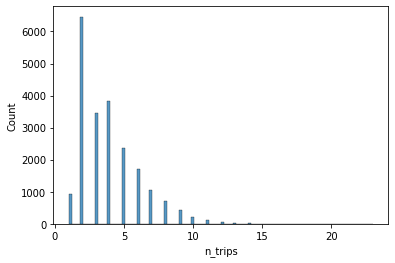

In [33]:
# Replace NA trip counts with 0
sns.histplot(df['n_trips'])
df['n_trips'][df['n_trips'].isna()] = 0
#df = df[df['n_trips']>0]
df = df[df['n_trips']<10]

In [34]:
[c for c in df]

['HOUSEID',
 'PERSONID',
 'R_AGE',
 'EDUC',
 'R_RACE',
 'R_SEX',
 'WRK_HOME',
 'WKFTPT',
 'OCCAT',
 'DRIVER',
 'TRAVDAY',
 'n_trips',
 'dist_to_work',
 'dist_to_shopping',
 'dist_to_family',
 'dist_to_school_or_church',
 'dist_to_relatives',
 'dist_to_social',
 'HH_CBSA',
 'HOMEOWN',
 'HHSIZE',
 'HHVEHCNT',
 'HHFAMINC',
 'NUMADLT',
 'YOUNGCHILD',
 'WRKCOUNT',
 'MSACAT',
 'MSASIZE',
 'URBAN',
 'URBANSIZE',
 'URBRUR',
 'LIF_CYC']

In [35]:
df.shape

(30558, 32)

## Reason for Model

In [36]:
ny_trip_count

,HOUSEID,PERSONID,n_trips,dist_to_work,dist_to_shopping,dist_to_family,dist_to_school_or_church,dist_to_relatives,dist_to_social
0,30000012,1,9,"(5.0, 11.0]",NaN,NaN,NaN,"(11.0, 99.0]","(2.0, 5.0]"
1,30000082,1,5,"(1.0, 2.0]",NaN,"(1.0, 2.0]",NaN,NaN,"(-0.001, 1.0]"
2,30000082,2,5,NaN,"(1.0, 2.0]",NaN,NaN,NaN,"(11.0, 99.0]"
3,30000380,1,3,NaN,"(1.0, 2.0]",NaN,NaN,NaN,NaN
4,30000380,2,8,"(-0.001, 1.0]","(1.0, 2.0]",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
22054,40793808,1,2,NaN,NaN,NaN,NaN,NaN,"(2.0, 5.0]"
22055,40793808,2,9,NaN,"(2.0, 5.0]","(2.0, 5.0]",NaN,NaN,"(1.0, 2.0]"
22056,40793808,3,5,NaN,"(2.0, 5.0]",NaN,NaN,NaN,"(-0.001, 1.0]"
22057,40793974,1,7,NaN,"(5.0, 11.0]",NaN,NaN,"(2.0, 5.0]","(2.0, 5.0]"


In [37]:
ny_trip_check = ny_trip[['HOUSEID','PERSONID','WHYTRP90']].groupby(['HOUSEID','PERSONID']).count().reset_index()
ny_check = nyorker.merge(ny_trip_check, how = 'left', left_on=['HOUSEID','PERSONID'],right_on=['HOUSEID','PERSONID'])

In [38]:
ny_check['WHYTRP90'][ny_check['WHYTRP90']>0] =1
ny_check['WHYTRP90'][ny_check['WHYTRP90'].isna()] =0

In [39]:
hh_rate = ny_check.groupby(['HOUSEID']).agg({'HOUSEID':'count',
                                  'WHYTRP90':'sum'})

hh_hitrate = sum(hh_rate['WHYTRP90']==0)/hh_rate.shape[0]*100

print('of ',str(hh_rate.shape[0]),' households, ',str(hh_hitrate), '% did not provide any trip info')

of  15230  households,  18.01050558108995 % did not provide any trip info


In [40]:
person_hitrate = sum(ny_check['WHYTRP90']==0)/ny_check.shape[0]*100

print('of', str(ny_check.shape[0]),' person info,',str(person_hitrate),'% did not provide any trip info')


of 31051  person info, 30.8428069949438 % did not provide any trip info


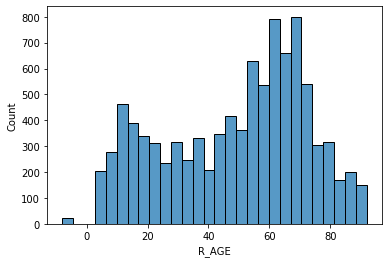

In [41]:
sns.histplot(ny_check['R_AGE'][ny_check['WHYTRP90']==0])

# not only those too young missing

### Therefore to create predictive model to help 'fill up' missing trip info to provide household level trip estimates. 

other reccommendation: for future survey can get volunteer to provide some of the key features of family members (e.g. dist to workplace or school) to help provide estimate of houshold total trips

## 2. EDA & Feature Engineering 

### 2.1. Train, Test, Split

In [42]:
x_col = [c for c in df if c not in ["HOUSEID","PERSONID","n_trips"]]
x_df = df[x_col]
y_df = df['n_trips']

x_train , x_test, y_train, y_test = model_selection.train_test_split(x_df, y_df, test_size = 0.2, random_state = 888)

In [43]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24446 entries, 16732 to 10939
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype            
---  ------                    --------------  -----            
 0   R_AGE                     24446 non-null  int64            
 1   EDUC                      24446 non-null  int64            
 2   R_RACE                    24446 non-null  int64            
 3   R_SEX                     24446 non-null  int64            
 4   WRK_HOME                  24446 non-null  int64            
 5   WKFTPT                    24446 non-null  int64            
 6   OCCAT                     24446 non-null  int64            
 7   DRIVER                    24446 non-null  int64            
 8   TRAVDAY                   24446 non-null  int64            
 9   dist_to_work              5498 non-null   interval[float64]
 10  dist_to_shopping          7119 non-null   interval[float64]
 11  dist_to_family            5441 non-nu

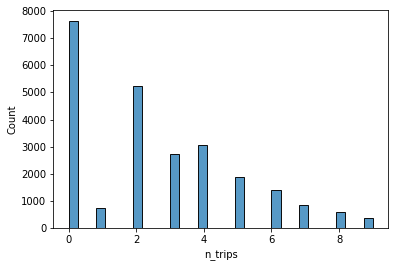

In [44]:
sns.histplot(y_train)

In [45]:
# use log transformation of n_trips (y)

#sns.histplot(np.log(y_train))

#y_train = np.log(y_train)
#y_test = np.log(y_test)

### 2.2. Feature Engineering

#### Age (R_AGE)

55 count of people with no age.  0.0002762702755890612 %.


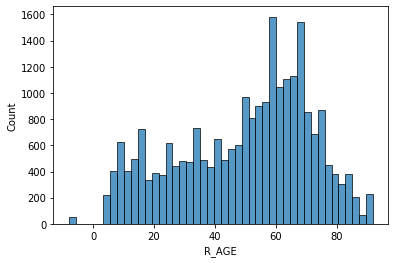

In [46]:
print(str(sum(x_train['R_AGE']<0)), "count of people with no age. ",str(sum(nyorker['R_AGE']<0)/person.shape[0]),"%.")

sns.histplot(x_train['R_AGE'])

# impute missing values (<0) with mean age
mean_age = round(x_train['R_AGE'][x_train['R_AGE']>0].mean())
x_train['R_AGE'][x_train['R_AGE']<0] = mean_age
x_test['R_AGE'][x_test['R_AGE']<0] = mean_age

In [47]:
x_train['AGE_bins']= 'NA'
x_train.loc[x_train['R_AGE'].between(5,15,inclusive = True), 'AGE_bins'] = "5_to_15"
x_train.loc[x_train['R_AGE'].between(16,25,inclusive = True), 'AGE_bins'] = "16_to_25"
x_train.loc[x_train['R_AGE'].between(26,35,inclusive = True), 'AGE_bins'] = "26_to_35"
x_train.loc[x_train['R_AGE'].between(36,45,inclusive = True), 'AGE_bins'] = "36_to_45"
x_train.loc[x_train['R_AGE'].between(46,55,inclusive = True), 'AGE_bins'] = "46_to_55"
x_train.loc[x_train['R_AGE'].between(56,65,inclusive = True), 'AGE_bins'] = "56_to_65"
x_train.loc[x_train['R_AGE'].between(66,75,inclusive = True), 'AGE_bins'] = "66_to_75"
x_train.loc[x_train['R_AGE']>75, 'AGE_bins'] = "more_than_75"

x_test['AGE_bins']= 'NA'
x_test.loc[x_test['R_AGE'].between(5,15,inclusive = True), 'AGE_bins'] = "5_to_15"
x_test.loc[x_test['R_AGE'].between(16,25,inclusive = True), 'AGE_bins'] = "16_to_25"
x_test.loc[x_test['R_AGE'].between(26,35,inclusive = True), 'AGE_bins'] = "26_to_35"
x_test.loc[x_test['R_AGE'].between(36,45,inclusive = True), 'AGE_bins'] = "36_to_45"
x_test.loc[x_test['R_AGE'].between(46,55,inclusive = True), 'AGE_bins'] = "46_to_55"
x_test.loc[x_test['R_AGE'].between(56,65,inclusive = True), 'AGE_bins'] = "56_to_65"
x_test.loc[x_test['R_AGE'].between(66,75,inclusive = True), 'AGE_bins'] = "66_to_75"
x_test.loc[x_test['R_AGE']>75, 'AGE_bins'] = "more_than_75"


              counts  percentage
56_to_65        5264   21.533175
66_to_75        4235   17.323898
46_to_55        3621   14.812239
5_to_15         2387    9.764379
36_to_45        2346    9.596662
26_to_35        2344    9.588481
more_than_75    2261    9.248957
16_to_25        1988    8.132210


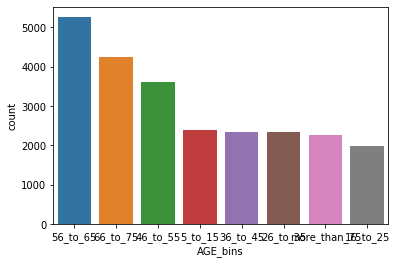

In [48]:
cat_col_prop(x_train,'AGE_bins')

#### Educational Attainment (EDUC)

    counts  percentage
 3    6071   24.834329
 5    5306   21.704982
 2    4834   19.774196
 4    4695   19.205596
-1    1907    7.800867
 1    1610    6.585945
-7      15    0.061360
-8       8    0.032725


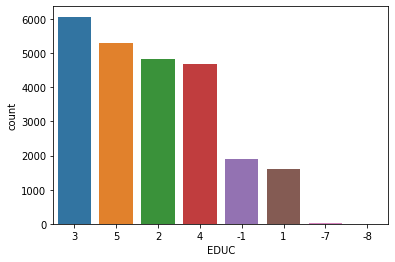

In [49]:
cat_col_prop(x_train,'EDUC')
# approx 8% missing values (<0). To take note of but will addresss in one-hot encoding

#### Race (R_RACE)

     counts  percentage
 1    21823   89.270228
 2      801    3.276610
 3      780    3.190706
 6      521    2.131228
 97     305    1.247648
-7      121    0.494969
 4       65    0.265892
 5       17    0.069541
-8       13    0.053178


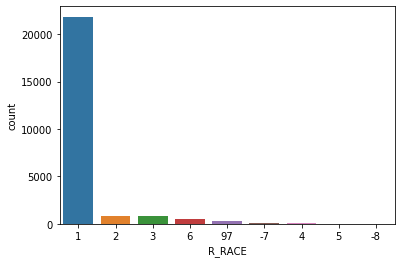

In [50]:
cat_col_prop(x_train,'R_RACE')
# approx 1% missing values (<0). To take note of but will address in one-hot encoding
# Significant proportion of members 'white'

#### Gender (R_SEX)

    counts  percentage
 2   12825   52.462571
 1   11592   47.418801
-7      25    0.102266
-8       4    0.016363


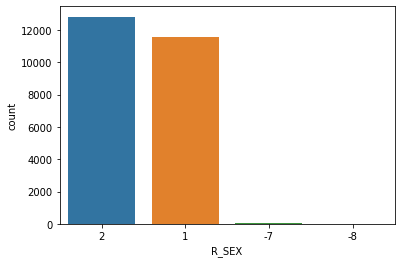

In [51]:
cat_col_prop(x_train, 'R_SEX')
# <1% missing values. To take note but will be addressed in one-hot encoding

#### Work From Home (WRK_HOME)

    counts  percentage
-1   12161   49.746380
 2   10540   43.115438
 1    1301    5.321934
-9     443    1.812157
-7       1    0.004091


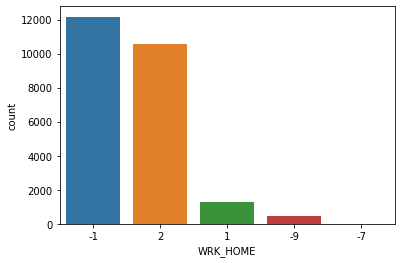

In [52]:
cat_col_prop(x_train,'WRK_HOME')
# Significant proportion -1 (50%) which is the appropriate skip (due to not working) - to address in one-hot

#### Work - Part Time or Full Time (WKFTPT)

    counts  percentage
-1   12604   51.558537
 1    9167   37.498977
 2    2668   10.913851
-7       6    0.024544
-8       1    0.004091


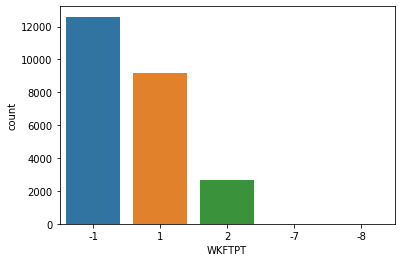

In [53]:
cat_col_prop(x_train,'WKFTPT')
# Significant proportion -1 (52%) which is the appropriate skip (due to not working) - to address in one-hot

#### Job Category (OCCAT)

     counts  percentage
-1    12161   49.746380
 4     6481   26.511495
 1     2547   10.418882
 3     1425    5.829175
 2     1370    5.604189
-9      443    1.812157
 97      13    0.053178
-8        3    0.012272
-7        3    0.012272


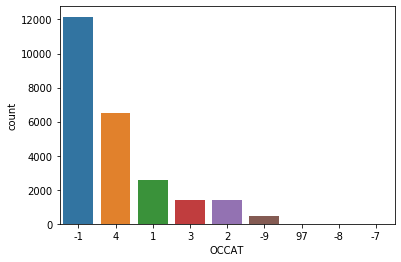

In [54]:
cat_col_prop(x_train,'OCCAT')
# Significant proportion -1 (50%) which is the appropriate skip (due to not working) - to address in one-hot

#### Driver Status (DRIVER)

    counts  percentage
 1   20591   84.230549
-1    2151    8.798986
 2    1704    6.970466


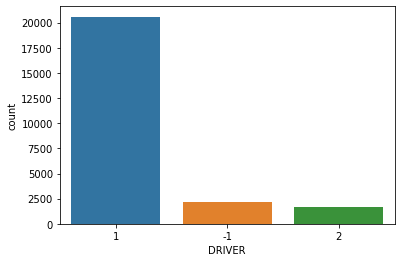

In [55]:
cat_col_prop(x_train,'DRIVER')

#Significant proportion -1 (8.7%) (due to too young) - to address in one-hot encoding
#sns.boxplot(data = x_train, x='DRIVER',y='AGE_bins')

#### Travel Day (TRAVDAY)

   counts  percentage
1    3621   14.812239
2    3585   14.664976
7    3504   14.333633
5    3475   14.215004
6    3474   14.210914
3    3453   14.125010
4    3334   13.638223


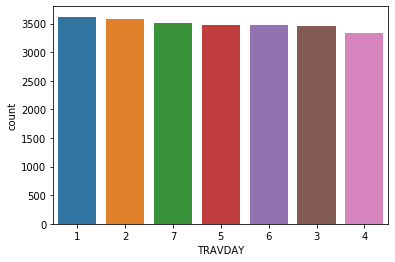

In [56]:
cat_col_prop(x_train,'TRAVDAY')

#### Core Based Statiscal Area FIPS code (HH_CBSA)

       counts  percentage
XXXXX   14490   59.273501
35620    7368   30.139900
40380    1399    5.722818
15380    1189    4.863781


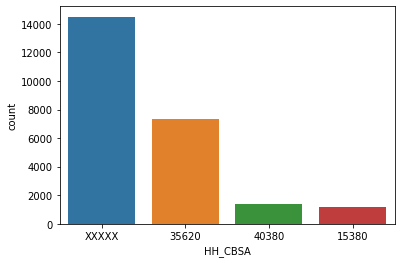

In [57]:
#Core Based Statistical Area (CBSA) FIPS code for the respondent's home address

cat_col_prop(x_train,'HH_CBSA')

# significant number of households under the 'XXXXX=Suppressed, in an MSA of less than 1 million ' category

####  Home Ownership (HOMEOWN)

     counts  percentage
 1    20584   84.201914
 2     3676   15.037225
 97     183    0.748589
-7        3    0.012272


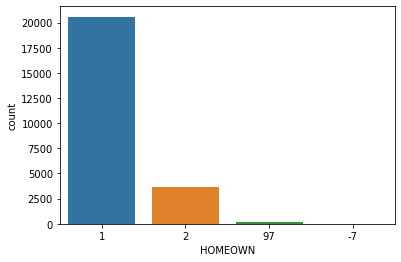

In [58]:
cat_col_prop(x_train,'HOMEOWN')
#Small count with missing value 2. to address in one-hot encoding

#### Household Vehicle Count (HHVEHCNT)

    counts  percentage
2    10851   44.387630
1     6438   26.335597
3     4443   18.174753
4     1740    7.117729
5      627    2.564837
6      224    0.916305
7       77    0.314980
8       23    0.094085
11      12    0.049088
9        8    0.032725
12       3    0.012272
________
new HHVEHCNT
    counts  percentage
2    10851   44.387630
1     6438   26.335597
3     4443   18.174753
>3    2714   11.102021


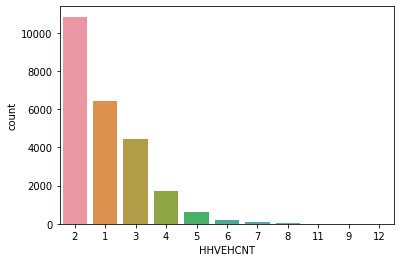

In [59]:
#count of household vehicles

cat_col_prop(x_train,'HHVEHCNT')

# as group size significantly smaller from 4 and above to bin to a single group

x_train['HHVEHCNT'][x_train['HHVEHCNT']>3] = ">3"
x_test['HHVEHCNT'][x_test['HHVEHCNT']>3] = ">3"

print("________")
print("new HHVEHCNT")
print(pd.concat([x_train['HHVEHCNT'].value_counts(),
          x_train['HHVEHCNT'].value_counts(normalize = True).mul(100)],axis = 1, keys = ('counts','percentage'))
    )

#### Family Income (HHFAMINC)

     counts  percentage
 6     4384   17.933404
 7     3667   15.000409
 8     3019   12.349669
 5     2605   10.656140
 4     1903    7.784505
 9     1765    7.219995
 11    1745    7.138182
 10    1701    6.958194
 3     1561    6.385503
 2      747    3.055715
-7      711    2.908451
 1      536    2.192588
-8      102    0.417246


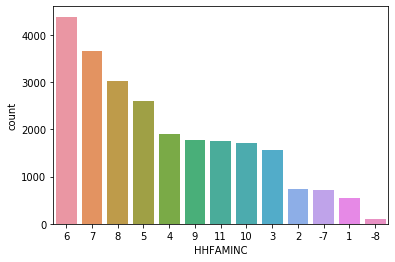

In [60]:
cat_col_prop(x_train,'HHFAMINC')
# approx 3% missing (<0) to address in one-hot encoding

#### Adult Ratio  (NUMADLT)

    counts  percentage
2    15534   63.544138
1     4091   16.734844
3     3333   13.634132
4     1149    4.700155
5      266    1.088113
6       42    0.171807
7       16    0.065450
10       9    0.036816
8        6    0.024544


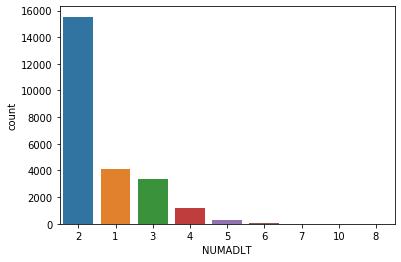

In [61]:
cat_col_prop(x_train, 'NUMADLT')
#no missing values

Before
          counts  percentage
1.000000   16956   69.361041
0.500000    2706   11.069296
0.666667    1849    7.563610
0.400000     846    3.460689
0.750000     644    2.634378
0.333333     474    1.938968
0.600000     349    1.427636
0.800000     188    0.769042
0.250000      85    0.347705
0.285714      81    0.331343
0.714286      46    0.188170
0.833333      38    0.155445
0.571429      35    0.143173
0.428571      33    0.134991
0.375000      20    0.081813
0.200000      18    0.073632
0.444444      15    0.061360
0.222222      15    0.061360
0.625000      13    0.053178
0.700000      10    0.040906
0.166667      10    0.040906
0.857143       6    0.024544
0.142857       5    0.020453
0.363636       4    0.016363

After
               counts  percentage
1               16956   69.361041
more_than_0.5    5884   24.069377
less_than_0.5    1606    6.569582


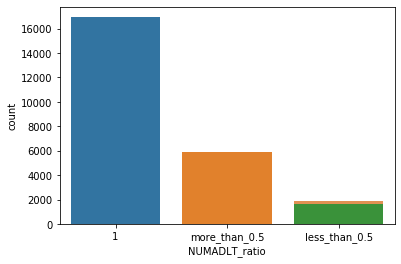

In [62]:
#Convert against proportion of Household size
x_train['NUMADLT'] = x_train['NUMADLT']/x_train['HHSIZE']
x_test['NUMADLT'] = x_test['NUMADLT']/x_test['HHSIZE']
print('Before')
cat_col_prop(x_train,'NUMADLT')
#significant number of varying factors
#to bin into groups
x_train['NUMADLT_ratio'] = 'NA'
x_train.loc[x_train['NUMADLT']==0, 'NUMADLT_ratio'] = '0'
x_train.loc[x_train['NUMADLT'].between(0,0.5,inclusive = False),'NUMADLT_ratio'] = 'less_than_0.5'
x_train.loc[x_train['NUMADLT'].between(0.5,1, inclusive = True),'NUMADLT_ratio'] = 'more_than_0.5'
x_train.loc[x_train['NUMADLT']==1,'NUMADLT_ratio'] ='1'
print('')
print('After')
cat_col_prop(x_train,'NUMADLT_ratio')


x_test['NUMADLT_ratio'] = 'NA'
x_test.loc[x_test['NUMADLT']==0, 'NUMADLT_ratio'] = '0'
x_test.loc[x_test['NUMADLT'].between(0,0.5,inclusive = False),'NUMADLT_ratio'] = 'less_than_0.5'
x_test.loc[x_test['NUMADLT'].between(0.5,1, inclusive = True),'NUMADLT_ratio'] = 'more_than_0.5'
x_test.loc[x_test['NUMADLT']==1,'NUMADLT_ratio'] ='1'

#### Young Child Ratio (YOUNGCHILD)

   counts  percentage
0   22321   91.307371
1    1600    6.545038
2     474    1.938968
3      45    0.184079
5       4    0.016363
4       2    0.008181


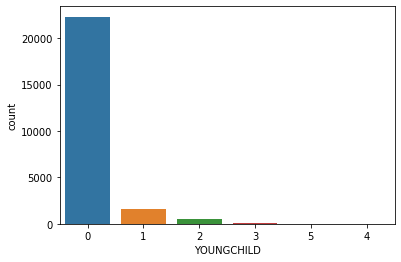

In [63]:
cat_col_prop(x_train,'YOUNGCHILD')

               counts  percentage
0               22321   91.307371
less_than_0.5    1836    7.510431
more_than_0.5     289    1.182197


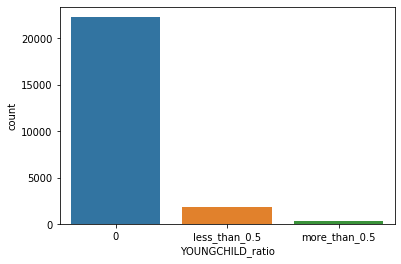

In [64]:
#Convert against proportion of Household size

x_train['YOUNGCHILD'] = x_train['YOUNGCHILD']/x_train['HHSIZE']
x_test['YOUNGCHILD'] = x_test['YOUNGCHILD']/x_test['HHSIZE']

#Bin to groups
x_train['YOUNGCHILD_ratio'] = 'NA'
x_train.loc[x_train['YOUNGCHILD']==0,'YOUNGCHILD_ratio']= '0'
x_train.loc[x_train['YOUNGCHILD'].between(0,0.5,inclusive = False),'YOUNGCHILD_ratio'] = 'less_than_0.5'
x_train.loc[x_train['YOUNGCHILD'].between(0.5,1, inclusive = True),'YOUNGCHILD_ratio'] = 'more_than_0.5'
x_train.loc[x_train['YOUNGCHILD']==1,'YOUNGCHILD_ratio'] ='1'
 

cat_col_prop(x_train,'YOUNGCHILD_ratio')    

x_test['YOUNGCHILD_ratio'] = 'NA'
x_test.loc[x_test['YOUNGCHILD']==0,'YOUNGCHILD_ratio']= '0'
x_test.loc[x_test['YOUNGCHILD'].between(0,0.5,inclusive = False),'YOUNGCHILD_ratio'] = 'less_than_0.5'
x_test.loc[x_test['YOUNGCHILD'].between(0.5,1, inclusive = True),'YOUNGCHILD_ratio'] = 'more_than_0.5'
x_test.loc[x_test['YOUNGCHILD']==1,'YOUNGCHILD_ratio'] ='1'
 


#### Worker Count Proportion (WRKCOUNT)

   counts  percentage
2    8386   34.304181
1    7450   30.475333
0    6390   26.139246
3    1659    6.786386
4     502    2.053506
5      47    0.192260
6       6    0.024544
7       6    0.024544


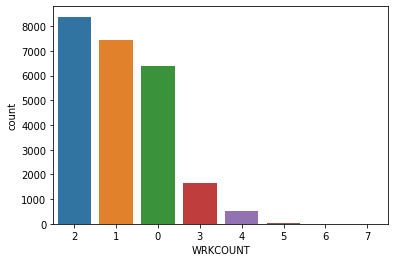

In [65]:
cat_col_prop(x_train,'WRKCOUNT')

               counts  percentage
more_than_0.5    8147   33.326516
0                6390   26.139246
1                6127   25.063405
less_than_0.5    3782   15.470834


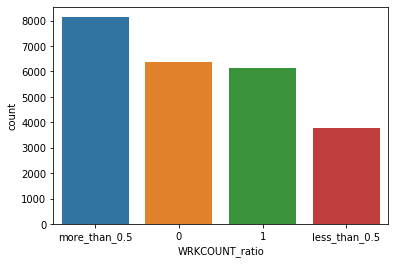

In [66]:
#Convert against proportion of Household size

x_train['WRKCOUNT'] = x_train['WRKCOUNT']/x_train['HHSIZE']
x_test['WRKCOUNT'] = x_test['WRKCOUNT']/x_test['HHSIZE']

#Bin to groups
x_train['WRKCOUNT_ratio'] = 'NA'
x_train.loc[x_train['WRKCOUNT']==0,'WRKCOUNT_ratio']= '0'
x_train.loc[x_train['WRKCOUNT'].between(0,0.5,inclusive = False),'WRKCOUNT_ratio'] = 'less_than_0.5'
x_train.loc[x_train['WRKCOUNT'].between(0.5,1, inclusive = True),'WRKCOUNT_ratio'] = 'more_than_0.5'
x_train.loc[x_train['WRKCOUNT']==1,'WRKCOUNT_ratio'] ='1'

cat_col_prop(x_train,'WRKCOUNT_ratio')

x_test['WRKCOUNT_ratio'] = 'NA'
x_test.loc[x_test['WRKCOUNT']==0,'WRKCOUNT_ratio']= '0'
x_test.loc[x_test['WRKCOUNT'].between(0,0.5,inclusive = False),'WRKCOUNT_ratio'] = 'less_than_0.5'
x_test.loc[x_test['WRKCOUNT'].between(0.5,1, inclusive = True),'WRKCOUNT_ratio'] = 'more_than_0.5'
x_test.loc[x_test['WRKCOUNT']==1,'WRKCOUNT_ratio'] ='1'

 

#### Household Size (HHSIZE)

Before
    counts  percentage
2    10479   42.865909
3     4179   17.094821
4     3830   15.667185
1     3527   14.427718
5     1558    6.373231
6      489    2.000327
7      212    0.867218
8       94    0.384521
9       43    0.175898
10      31    0.126810
11       4    0.016363

After
         counts  percentage
2         10479   42.865909
above_3    6261   25.611552
3          4179   17.094821
1          3527   14.427718


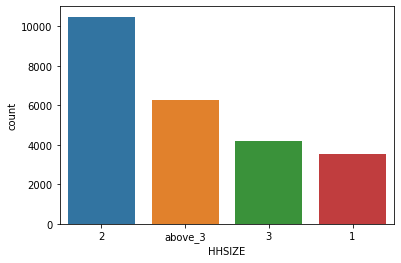

In [67]:
#count of household members
print("Before")
cat_col_prop(x_train,'HHSIZE')

# to bin tail HHSIZE

x_train['HHSIZE'][x_train['HHSIZE']>3] = "above_3"

print("")
print("After")

cat_col_prop(x_train,'HHSIZE')

x_test['HHSIZE'][x_test['HHSIZE']>3] = " above_3"

#### Metropolitan Statistical Area (MSACAT)


   counts  percentage
3   10557   43.184979
1    7368   30.139900
4    3933   16.088522
2    2588   10.586599


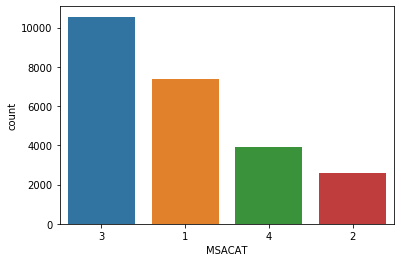

In [68]:
cat_col_prop(x_train,'MSACAT')
             
#no missing values and relatively proportional distribution

#### Population size of MSA (MSASIZE)

   counts  percentage
5    7368   30.139900
1    6148   25.149309
6    3933   16.088522
3    3312   13.548229
4    2588   10.586599
2    1097    4.487442


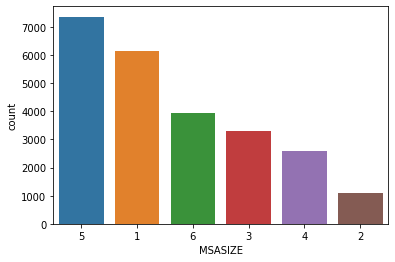

In [69]:
cat_col_prop(x_train,'MSASIZE')
             
#no missing values and relatively proportional distribution

#### House in Urban or Rural Area (URBAN)

Before
   counts  percentage
1   13700   56.041888
4    8379   34.275546
2    2363    9.666203
3       4    0.016363

After
       counts  percentage
urban   16063   65.708091
rural    8383   34.291909


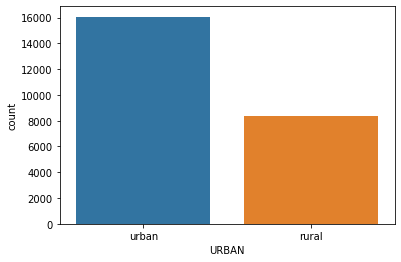

In [70]:
print('Before')
cat_col_prop(x_train,'URBAN')

# combine 1 and 2 (in an urban area and in an urban cluster ) & combine 3 and 4 (surround by urban and not in urban)

x_train['URBAN'][x_train['URBAN'].isin([1,2])] = 'urban'
x_train['URBAN'][x_train['URBAN'].isin([3,4])] = 'rural'

print("")
print('After')

cat_col_prop(x_train, 'URBAN')

x_test['URBAN'][x_test['URBAN'].isin([1,2])] = 'urban'
x_test['URBAN'][x_test['URBAN'].isin([3,4])] = 'rural'

#### URBANSIZE

   counts  percentage
6   10746   43.958112
5    4723   19.320134
1    3714   15.192670
3    2753   11.261556
2    2510   10.267528


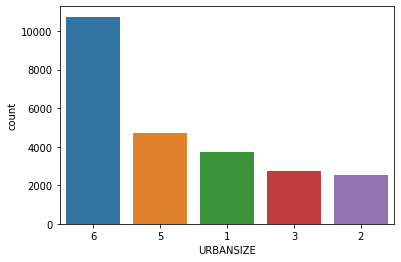

In [71]:
#06 = not in an urbanised area 
#05 - 1 million with heavy rail 

#Relatively proportional classes
cat_col_prop(x_train,'URBANSIZE')

#### URBRUR

   counts  percentage
1   16063   65.708091
2    8383   34.291909


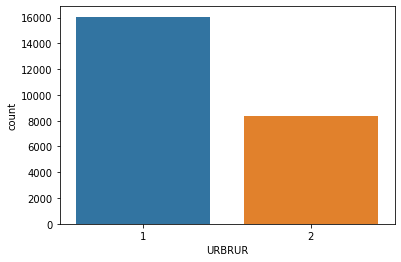

In [72]:
cat_col_prop(x_train,'URBRUR')
# missing values nor disproportion

#### LIF_CYC 

    counts  percentage
10    6783   27.746871
2     5578   22.817639
6     3667   15.000409
4     2445   10.001636
1     1847    7.555428
9     1680    6.872290
8     1649    6.745480
5      453    1.853064
7      208    0.850855
3      136    0.556328


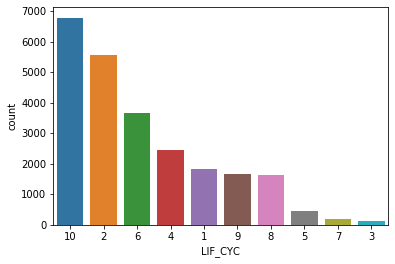

In [73]:
cat_col_prop(x_train,"LIF_CYC")

# No major disproportion

## 3. One-Hot- Encoding

In [74]:
x_train.dtypes

R_AGE                                   int64
EDUC                                    int64
R_RACE                                  int64
R_SEX                                   int64
WRK_HOME                                int64
WKFTPT                                  int64
OCCAT                                   int64
DRIVER                                  int64
TRAVDAY                                 int64
dist_to_work                interval[float64]
dist_to_shopping            interval[float64]
dist_to_family              interval[float64]
dist_to_school_or_church    interval[float64]
dist_to_relatives           interval[float64]
dist_to_social              interval[float64]
HH_CBSA                                object
HOMEOWN                                 int64
HHSIZE                                 object
HHVEHCNT                               object
HHFAMINC                                int64
NUMADLT                               float64
YOUNGCHILD                        

In [75]:
to_obj = ['EDUC','R_RACE','AGE_bins','HHFAMINC','HOMEOWN','R_SEX','TRAVDAY','WRK_HOME','WKFTPT','OCCAT','DRIVER','MSACAT','MSASIZE','URBAN','URBANSIZE','URBRUR','LIF_CYC','dist_to_work','dist_to_shopping','dist_to_family','dist_to_school_or_church','dist_to_relatives','dist_to_social']

x_train[to_obj] = x_train[to_obj].astype(str)
x_test[to_obj]= x_test[to_obj].astype(str)

x_train.drop(['R_AGE'], axis = 1, inplace =True)
x_test.drop(['R_AGE'],axis = 1, inplace = True)

In [76]:
one_hot_col = [c for c in x_train if x_train[c].dtypes == 'O' ]
x_train = pd.concat([x_train,pd.get_dummies(x_train[one_hot_col],prefix = one_hot_col)],axis = 1)
x_train.drop(one_hot_col, axis = 1, inplace = True)

x_test = pd.concat([x_test,pd.get_dummies(x_test[one_hot_col],prefix = one_hot_col)],axis = 1)
x_test.drop(one_hot_col, axis = 1, inplace = True)

In [77]:
#drop all negative value columns  

na_cols_train =[c for c in x_train if ('NA' in c) or ('-' in c) or ('nan' in c)]

x_train.drop(na_cols_train, axis = 1, inplace = True)


na_cols_test =[c for c in x_test if ('NA' in c) or ('-' in c) or ('nan' in c)]
x_test.drop(na_cols_test, axis = 1 , inplace = True)

In [78]:

dist_cols = [c for c in x_train if ('dist' in c)]

x_train_with_dist = x_train[dist_cols]
x_test_with_dist = x_test[dist_cols]

x_train.drop(dist_cols, axis =1, inplace = True)
x_test.drop(dist_cols, axis =1, inplace = True)


#y_train = y_train.astype('int64')
#y_test = y_test.astype('int64')

In [79]:
x_train.shape

(24446, 108)

In [80]:

x_train_with_dist = pd.concat([x_train,x_train_with_dist],axis=1)
x_test_with_dist = pd.concat([x_test,x_test_with_dist],axis=1)


In [81]:
dist_dict = {'dist_to_work_(1.0, 2.0]':'dist_to_work_between_1_and_2',
            'dist_to_work_(11.0, 99.0]':'dist_to_work_more_than_11',
            'dist_to_work_(2.0, 5.0]':'dist_to_work_between_2_and_5',
            'dist_to_work_(5.0, 11.0]':'dist_to_work_between_5_and_11',
             'dist_to_shopping_(1.0, 2.0]':'dist_to_shopping_between_1_and_2',
             'dist_to_shopping_(11.0, 99.0]':'dist_to_shopping_more_than_11',
             'dist_to_shopping_(2.0, 5.0]':'dist_to_shopping_between_2_and_5',
             'dist_to_shopping_(5.0, 11.0]':'dist_to_shopping_between_5_and_11',
             'dist_to_family_(1.0, 2.0]':'dist_to_family_between_1_and_2',
             'dist_to_family_(11.0, 99.0]':'dist_to_family_greater_than_11',
             'dist_to_family_(2.0, 5.0]':'dist_to_family_between_2_and_5',
             'dist_to_family_(5.0, 11.0]':'dist_to_family_between_5_and_11',
             'dist_to_school_or_church_(1.0, 2.0]':'dist_to_school_or_church_between_1_and_2',
             'dist_to_school_or_church_(11.0, 99.0]':'dist_to_school_or_church_greater_than_11',
             'dist_to_school_or_church_(2.0, 5.0]':'dist_to_school_or_church_between_2_and_5',
             'dist_to_school_or_church_(5.0, 11.0]':'dist_to_school_or_church_between_5_and_11',
             'dist_to_relatives_(1.0, 2.0]':'dist_to_relatvies_between_1_and_2',
             'dist_to_relatives_(11.0, 99.0]':'dist_to_relatvies_greater_than_11',
             'dist_to_relatives_(2.0, 5.0]':'dist_to_relatvies_between_2_and_5',
             'dist_to_relatives_(5.0, 11.0]':'dist_to_relatvies_between_5_and_11',
             'dist_to_social_(1.0, 2.0]':'dist_to_social_between_1_and_2',
             'dist_to_social_(11.0, 99.0]':'dist_to_social_greater_than_11',
             'dist_to_social_(2.0, 5.0]':'dist_to_social_between_2_and_5',
             'dist_to_social_(5.0, 11.0]':'dist_to_social_between_5_and_11'}

dist_cols = [c for c in x_train_with_dist if 'dist' in c]

x_train_with_dist.rename(columns=dist_dict,inplace = True)
x_test_with_dist.rename(columns = dist_dict, inplace = True)

In [82]:
x_test

,NUMADLT,YOUNGCHILD,WRKCOUNT,EDUC_1,EDUC_2,EDUC_3,EDUC_4,EDUC_5,R_RACE_1,R_RACE_2,...,NUMADLT_ratio_1,NUMADLT_ratio_less_than_0.5,NUMADLT_ratio_more_than_0.5,YOUNGCHILD_ratio_0,YOUNGCHILD_ratio_less_than_0.5,YOUNGCHILD_ratio_more_than_0.5,WRKCOUNT_ratio_0,WRKCOUNT_ratio_1,WRKCOUNT_ratio_less_than_0.5,WRKCOUNT_ratio_more_than_0.5
1564,1.000000,0.0,0.500000,0,0,0,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1
7719,1.000000,0.0,1.000000,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0
13490,1.000000,0.0,0.500000,0,0,1,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
4050,0.600000,0.0,0.200000,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,1,0
9098,0.666667,0.0,0.666667,0,0,0,1,0,1,0,...,0,0,1,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3858,1.000000,0.0,1.000000,0,0,0,1,0,1,0,...,1,0,0,1,0,0,0,1,0,0
17368,1.000000,0.0,0.000000,0,0,1,0,0,1,0,...,1,0,0,1,0,0,1,0,0,0
26781,1.000000,0.0,0.000000,0,0,0,0,1,1,0,...,1,0,0,1,0,0,1,0,0,0
3503,1.000000,0.0,0.500000,0,0,0,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1


In [83]:
x_test_with_dist

,NUMADLT,YOUNGCHILD,WRKCOUNT,EDUC_1,EDUC_2,EDUC_3,EDUC_4,EDUC_5,R_RACE_1,R_RACE_2,...,dist_to_school_or_church_between_2_and_5,dist_to_school_or_church_between_5_and_11,dist_to_relatvies_between_1_and_2,dist_to_relatvies_greater_than_11,dist_to_relatvies_between_2_and_5,dist_to_relatvies_between_5_and_11,dist_to_social_between_1_and_2,dist_to_social_greater_than_11,dist_to_social_between_2_and_5,dist_to_social_between_5_and_11
1564,1.000000,0.0,0.500000,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
7719,1.000000,0.0,1.000000,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
13490,1.000000,0.0,0.500000,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4050,0.600000,0.0,0.200000,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9098,0.666667,0.0,0.666667,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3858,1.000000,0.0,1.000000,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
17368,1.000000,0.0,0.000000,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
26781,1.000000,0.0,0.000000,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3503,1.000000,0.0,0.500000,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
[c for c in x_test_with_dist]

['NUMADLT',
 'YOUNGCHILD',
 'WRKCOUNT',
 'EDUC_1',
 'EDUC_2',
 'EDUC_3',
 'EDUC_4',
 'EDUC_5',
 'R_RACE_1',
 'R_RACE_2',
 'R_RACE_3',
 'R_RACE_4',
 'R_RACE_5',
 'R_RACE_6',
 'R_RACE_97',
 'R_SEX_1',
 'R_SEX_2',
 'WRK_HOME_1',
 'WRK_HOME_2',
 'WKFTPT_1',
 'WKFTPT_2',
 'OCCAT_1',
 'OCCAT_2',
 'OCCAT_3',
 'OCCAT_4',
 'OCCAT_97',
 'DRIVER_1',
 'DRIVER_2',
 'TRAVDAY_1',
 'TRAVDAY_2',
 'TRAVDAY_3',
 'TRAVDAY_4',
 'TRAVDAY_5',
 'TRAVDAY_6',
 'TRAVDAY_7',
 'HH_CBSA_15380',
 'HH_CBSA_35620',
 'HH_CBSA_40380',
 'HH_CBSA_XXXXX',
 'HOMEOWN_1',
 'HOMEOWN_2',
 'HOMEOWN_97',
 'HHSIZE_1',
 'HHSIZE_2',
 'HHSIZE_3',
 'HHSIZE_ above_3',
 'HHVEHCNT_1',
 'HHVEHCNT_2',
 'HHVEHCNT_3',
 'HHVEHCNT_>3',
 'HHFAMINC_1',
 'HHFAMINC_10',
 'HHFAMINC_11',
 'HHFAMINC_2',
 'HHFAMINC_3',
 'HHFAMINC_4',
 'HHFAMINC_5',
 'HHFAMINC_6',
 'HHFAMINC_7',
 'HHFAMINC_8',
 'HHFAMINC_9',
 'MSACAT_1',
 'MSACAT_2',
 'MSACAT_3',
 'MSACAT_4',
 'MSASIZE_1',
 'MSASIZE_2',
 'MSASIZE_3',
 'MSASIZE_4',
 'MSASIZE_5',
 'MSASIZE_6',
 'URBAN_ru

In [85]:
[c for c in x_train_with_dist]

['NUMADLT',
 'YOUNGCHILD',
 'WRKCOUNT',
 'EDUC_1',
 'EDUC_2',
 'EDUC_3',
 'EDUC_4',
 'EDUC_5',
 'R_RACE_1',
 'R_RACE_2',
 'R_RACE_3',
 'R_RACE_4',
 'R_RACE_5',
 'R_RACE_6',
 'R_RACE_97',
 'R_SEX_1',
 'R_SEX_2',
 'WRK_HOME_1',
 'WRK_HOME_2',
 'WKFTPT_1',
 'WKFTPT_2',
 'OCCAT_1',
 'OCCAT_2',
 'OCCAT_3',
 'OCCAT_4',
 'OCCAT_97',
 'DRIVER_1',
 'DRIVER_2',
 'TRAVDAY_1',
 'TRAVDAY_2',
 'TRAVDAY_3',
 'TRAVDAY_4',
 'TRAVDAY_5',
 'TRAVDAY_6',
 'TRAVDAY_7',
 'HH_CBSA_15380',
 'HH_CBSA_35620',
 'HH_CBSA_40380',
 'HH_CBSA_XXXXX',
 'HOMEOWN_1',
 'HOMEOWN_2',
 'HOMEOWN_97',
 'HHSIZE_1',
 'HHSIZE_2',
 'HHSIZE_3',
 'HHSIZE_above_3',
 'HHVEHCNT_1',
 'HHVEHCNT_2',
 'HHVEHCNT_3',
 'HHVEHCNT_>3',
 'HHFAMINC_1',
 'HHFAMINC_10',
 'HHFAMINC_11',
 'HHFAMINC_2',
 'HHFAMINC_3',
 'HHFAMINC_4',
 'HHFAMINC_5',
 'HHFAMINC_6',
 'HHFAMINC_7',
 'HHFAMINC_8',
 'HHFAMINC_9',
 'MSACAT_1',
 'MSACAT_2',
 'MSACAT_3',
 'MSACAT_4',
 'MSASIZE_1',
 'MSASIZE_2',
 'MSASIZE_3',
 'MSASIZE_4',
 'MSASIZE_5',
 'MSASIZE_6',
 'URBAN_rur

## 4. Models (first round run x_train to get low score then second run x_train_dist)

## 4.1. X_train

To train models using only data from person and household dataset. Doing so will allow current survey method to be sufficient in predicting trips of people who did not participate in the trips measuring but participated in the household and person information survey

### 4.1.1. Linear Models

#### 4.1.1.1. Standard Linear Regression

In [86]:
#Checking for multicollinearity through variance Inflation Factor 
#VIF=1, Very Less Multicollinearity
#VIF<5, Moderate Multicollinearity
#VIF>5, Extreme Multicollinearity (This is what we have to avoid)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model, model_selection, metrics


In [87]:
LRmodel = linear_model.LinearRegression()  #create the linear regression 
LRmodel.fit(x_train,y_train) #train the model using the training set 
LR_pred = LRmodel.predict(x_test) #use this model to predict the test data set 

In [88]:
print('R^2 score:\t\t\t\t',LRmodel.score(x_test, y_test)) #compute R^2 score 
print('Explained Variance: \t\t\t', metrics.explained_variance_score(y_test, LR_pred)) #compute explained variance score
print('Mean Absolute Error: \t\t\t', metrics.mean_absolute_error(y_test, LR_pred)) #compute MAE results
print('Mean Squared Error:\t\t\t', metrics.mean_squared_error(y_test, LR_pred)) #compute MSE results
print('Root Mean Squared Error:\t\t', metrics.mean_squared_error(y_test, LR_pred, squared = False)) #compute RSME results
print('Intercept:\t', LRmodel.intercept_) #find intercept value 
print('Coef:\t', np.sum(LRmodel.coef_!=0))#find no of features used in regression model 

R^2 score:				 0.08296314223337742
Explained Variance: 			 0.08309646224067424
Mean Absolute Error: 			 1.8226014681511524
Mean Squared Error:			 4.996107415681953
Root Mean Squared Error:		 2.2351973997125967
Intercept:	 -396634094717.1045
Coef:	 108


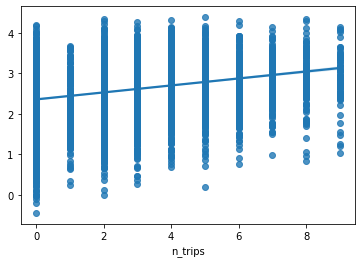

In [89]:
sns.regplot(y_test,LR_pred) #plotting predictions 

In [88]:
#calculate VIF scores to detect multicolinearity 

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x_train.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train.values, i)
                          for i in range(len(x_train.columns))]
  
print(vif_data)

                            feature        VIF
0                           NUMADLT  29.419768
1                        YOUNGCHILD  20.265531
2                          WRKCOUNT  60.693040
3                            EDUC_1   6.450828
4                            EDUC_2  21.028886
..                              ...        ...
103  YOUNGCHILD_ratio_more_than_0.5        inf
104                WRKCOUNT_ratio_0        inf
105                WRKCOUNT_ratio_1        inf
106    WRKCOUNT_ratio_less_than_0.5        inf
107    WRKCOUNT_ratio_more_than_0.5        inf

[108 rows x 2 columns]


In [89]:
vif_data.sort_values(by = 'VIF', ascending = False)

,feature,VIF
107,WRKCOUNT_ratio_more_than_0.5,inf
90,AGE_bins_16_to_25,inf
83,LIF_CYC_3,inf
84,LIF_CYC_4,inf
85,LIF_CYC_5,inf
...,...,...
54,HHFAMINC_3,2.732780
53,HHFAMINC_2,1.841463
50,HHFAMINC_1,1.605804
11,R_RACE_4,1.458688


In [90]:
# counting number of infinity features 

vif_data_inf = np.isinf(vif_data['VIF']).values.sum()
print("It contains " + str(vif_data_inf) + " infinite values")

It contains 66 infinite values


In [91]:
#cross validation to see if it will improve results 

folds = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = model_selection.cross_val_score(LRmodel, x_train, y_train, scoring='neg_mean_squared_error', cv=folds)

print('\nR2 score:',scores)


R2 score: [-1.28803766e+18  3.87274617e-02  4.56086261e-02  6.27799989e-02
  4.04063201e-02]


In [92]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
scores

array([-1288037661030546432.000000, 0.038727, 0.045609, 0.062780,
       0.040406])

In [93]:
start_time = time.time()
from sklearn.feature_selection import RFE


#specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1,133))}]


# perform grid search

rfe = RFE(LRmodel)             

# 3.2 call GridSearchCV()
model_cv = model_selection.GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = folds, 
                        verbose = 10,
                        return_train_score=True)      

# fit the model
model_cv.fit(x_train, y_train)   

print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))

Fitting 5 folds for each of 132 candidates, totalling 660 fits
[CV 1/5; 1/132] START n_features_to_select=1....................................
[CV 1/5; 1/132] END n_features_to_select=1;, score=(train=0.001, test=-0.000) total time=   2.5s
[CV 2/5; 1/132] START n_features_to_select=1....................................
[CV 2/5; 1/132] END n_features_to_select=1;, score=(train=0.001, test=0.000) total time=   2.5s
[CV 3/5; 1/132] START n_features_to_select=1....................................
[CV 3/5; 1/132] END n_features_to_select=1;, score=(train=0.003, test=0.003) total time=   2.2s
[CV 4/5; 1/132] START n_features_to_select=1....................................
[CV 4/5; 1/132] END n_features_to_select=1;, score=(train=0.001, test=-0.000) total time=   1.9s
[CV 5/5; 1/132] START n_features_to_select=1....................................
[CV 5/5; 1/132] END n_features_to_select=1;, score=(train=0.001, test=-0.001) total time=   1.8s
[CV 1/5; 2/132] START n_features_to_select=2.....

[CV 2/5; 10/132] END n_features_to_select=10;, score=(train=0.002, test=0.004) total time=   2.1s
[CV 3/5; 10/132] START n_features_to_select=10..................................
[CV 3/5; 10/132] END n_features_to_select=10;, score=(train=0.006, test=0.006) total time=   1.8s
[CV 4/5; 10/132] START n_features_to_select=10..................................
[CV 4/5; 10/132] END n_features_to_select=10;, score=(train=0.007, test=-0.001) total time=   1.9s
[CV 5/5; 10/132] START n_features_to_select=10..................................
[CV 5/5; 10/132] END n_features_to_select=10;, score=(train=0.004, test=0.001) total time=   1.8s
[CV 1/5; 11/132] START n_features_to_select=11..................................
[CV 1/5; 11/132] END n_features_to_select=11;, score=(train=0.004, test=0.002) total time=   1.7s
[CV 2/5; 11/132] START n_features_to_select=11..................................
[CV 2/5; 11/132] END n_features_to_select=11;, score=(train=0.004, test=0.004) total time=   1.8s
[CV 3/

[CV 3/5; 19/132] END n_features_to_select=19;, score=(train=0.013, test=0.010) total time=   1.9s
[CV 4/5; 19/132] START n_features_to_select=19..................................
[CV 4/5; 19/132] END n_features_to_select=19;, score=(train=0.019, test=0.016) total time=   1.9s
[CV 5/5; 19/132] START n_features_to_select=19..................................
[CV 5/5; 19/132] END n_features_to_select=19;, score=(train=0.015, test=0.008) total time=   2.2s
[CV 1/5; 20/132] START n_features_to_select=20..................................
[CV 1/5; 20/132] END n_features_to_select=20;, score=(train=0.019, test=0.017) total time=   2.3s
[CV 2/5; 20/132] START n_features_to_select=20..................................
[CV 2/5; 20/132] END n_features_to_select=20;, score=(train=0.009, test=0.010) total time=   1.8s
[CV 3/5; 20/132] START n_features_to_select=20..................................
[CV 3/5; 20/132] END n_features_to_select=20;, score=(train=0.013, test=0.010) total time=   2.2s
[CV 4/5

[CV 4/5; 28/132] END n_features_to_select=28;, score=(train=0.019, test=0.015) total time=   1.6s
[CV 5/5; 28/132] START n_features_to_select=28..................................
[CV 5/5; 28/132] END n_features_to_select=28;, score=(train=0.015, test=0.008) total time=   1.6s
[CV 1/5; 29/132] START n_features_to_select=29..................................
[CV 1/5; 29/132] END n_features_to_select=29;, score=(train=0.020, test=0.017) total time=   1.6s
[CV 2/5; 29/132] START n_features_to_select=29..................................
[CV 2/5; 29/132] END n_features_to_select=29;, score=(train=0.015, test=0.014) total time=   1.6s
[CV 3/5; 29/132] START n_features_to_select=29..................................
[CV 3/5; 29/132] END n_features_to_select=29;, score=(train=0.015, test=0.012) total time=   1.8s
[CV 4/5; 29/132] START n_features_to_select=29..................................
[CV 4/5; 29/132] END n_features_to_select=29;, score=(train=0.020, test=0.016) total time=   1.6s
[CV 5/5

[CV 5/5; 37/132] END n_features_to_select=37;, score=(train=0.020, test=0.018) total time=   1.7s
[CV 1/5; 38/132] START n_features_to_select=38..................................
[CV 1/5; 38/132] END n_features_to_select=38;, score=(train=0.020, test=0.016) total time=   1.6s
[CV 2/5; 38/132] START n_features_to_select=38..................................
[CV 2/5; 38/132] END n_features_to_select=38;, score=(train=0.022, test=0.020) total time=   1.6s
[CV 3/5; 38/132] START n_features_to_select=38..................................
[CV 3/5; 38/132] END n_features_to_select=38;, score=(train=0.040, test=0.034) total time=   1.7s
[CV 4/5; 38/132] START n_features_to_select=38..................................
[CV 4/5; 38/132] END n_features_to_select=38;, score=(train=0.024, test=0.022) total time=   1.6s
[CV 5/5; 38/132] START n_features_to_select=38..................................
[CV 5/5; 38/132] END n_features_to_select=38;, score=(train=0.020, test=0.018) total time=   1.8s
[CV 1/5

[CV 1/5; 47/132] END n_features_to_select=47;, score=(train=0.020, test=-1302269038472296923136.000) total time=   1.6s
[CV 2/5; 47/132] START n_features_to_select=47..................................
[CV 2/5; 47/132] END n_features_to_select=47;, score=(train=0.045, test=0.038) total time=   1.6s
[CV 3/5; 47/132] START n_features_to_select=47..................................
[CV 3/5; 47/132] END n_features_to_select=47;, score=(train=0.044, test=0.039) total time=   1.5s
[CV 4/5; 47/132] START n_features_to_select=47..................................
[CV 4/5; 47/132] END n_features_to_select=47;, score=(train=0.036, test=0.036) total time=   1.4s
[CV 5/5; 47/132] START n_features_to_select=47..................................
[CV 5/5; 47/132] END n_features_to_select=47;, score=(train=0.024, test=0.023) total time=   1.6s
[CV 1/5; 48/132] START n_features_to_select=48..................................
[CV 1/5; 48/132] END n_features_to_select=48;, score=(train=0.021, test=-2620454219

[CV 1/5; 56/132] END n_features_to_select=56;, score=(train=0.044, test=-1452210062945853112320.000) total time=   1.3s
[CV 2/5; 56/132] START n_features_to_select=56..................................
[CV 2/5; 56/132] END n_features_to_select=56;, score=(train=0.047, test=0.037) total time=   1.3s
[CV 3/5; 56/132] START n_features_to_select=56..................................
[CV 3/5; 56/132] END n_features_to_select=56;, score=(train=0.046, test=0.037) total time=   1.4s
[CV 4/5; 56/132] START n_features_to_select=56..................................
[CV 4/5; 56/132] END n_features_to_select=56;, score=(train=0.043, test=0.051) total time=   1.3s
[CV 5/5; 56/132] START n_features_to_select=56..................................
[CV 5/5; 56/132] END n_features_to_select=56;, score=(train=0.024, test=0.023) total time=   1.4s
[CV 1/5; 57/132] START n_features_to_select=57..................................
[CV 1/5; 57/132] END n_features_to_select=57;, score=(train=0.044, test=-1895384279

[CV 1/5; 65/132] END n_features_to_select=65;, score=(train=0.046, test=-1320871812530623744.000) total time=   1.2s
[CV 2/5; 65/132] START n_features_to_select=65..................................
[CV 2/5; 65/132] END n_features_to_select=65;, score=(train=0.047, test=0.037) total time=   1.2s
[CV 3/5; 65/132] START n_features_to_select=65..................................
[CV 3/5; 65/132] END n_features_to_select=65;, score=(train=0.048, test=0.036) total time=   1.2s
[CV 4/5; 65/132] START n_features_to_select=65..................................
[CV 4/5; 65/132] END n_features_to_select=65;, score=(train=0.044, test=0.047) total time=   1.2s
[CV 5/5; 65/132] START n_features_to_select=65..................................
[CV 5/5; 65/132] END n_features_to_select=65;, score=(train=0.047, test=0.038) total time=   1.2s
[CV 1/5; 66/132] START n_features_to_select=66..................................
[CV 1/5; 66/132] END n_features_to_select=66;, score=(train=0.046, test=-8919715788569

[CV 1/5; 74/132] END n_features_to_select=74;, score=(train=0.052, test=-2917223009081492504576.000) total time=   0.9s
[CV 2/5; 74/132] START n_features_to_select=74..................................
[CV 2/5; 74/132] END n_features_to_select=74;, score=(train=0.047, test=0.031) total time=   1.0s
[CV 3/5; 74/132] START n_features_to_select=74..................................
[CV 3/5; 74/132] END n_features_to_select=74;, score=(train=0.053, test=0.043) total time=   0.9s
[CV 4/5; 74/132] START n_features_to_select=74..................................
[CV 4/5; 74/132] END n_features_to_select=74;, score=(train=0.045, test=0.050) total time=   1.1s
[CV 5/5; 74/132] START n_features_to_select=74..................................
[CV 5/5; 74/132] END n_features_to_select=74;, score=(train=0.053, test=0.039) total time=   1.0s
[CV 1/5; 75/132] START n_features_to_select=75..................................
[CV 1/5; 75/132] END n_features_to_select=75;, score=(train=0.052, test=-5903574383

[CV 1/5; 83/132] END n_features_to_select=83;, score=(train=0.058, test=-493845671099748800.000) total time=   0.8s
[CV 2/5; 83/132] START n_features_to_select=83..................................
[CV 2/5; 83/132] END n_features_to_select=83;, score=(train=0.058, test=0.039) total time=   0.8s
[CV 3/5; 83/132] START n_features_to_select=83..................................
[CV 3/5; 83/132] END n_features_to_select=83;, score=(train=0.056, test=0.045) total time=   0.8s
[CV 4/5; 83/132] START n_features_to_select=83..................................
[CV 4/5; 83/132] END n_features_to_select=83;, score=(train=0.052, test=0.059) total time=   0.7s
[CV 5/5; 83/132] START n_features_to_select=83..................................
[CV 5/5; 83/132] END n_features_to_select=83;, score=(train=0.057, test=0.038) total time=   0.8s
[CV 1/5; 84/132] START n_features_to_select=84..................................
[CV 1/5; 84/132] END n_features_to_select=84;, score=(train=0.058, test=-89814431724343

[CV 1/5; 92/132] END n_features_to_select=92;, score=(train=0.060, test=-1440939409534783232.000) total time=   0.5s
[CV 2/5; 92/132] START n_features_to_select=92..................................
[CV 2/5; 92/132] END n_features_to_select=92;, score=(train=0.060, test=0.039) total time=   0.5s
[CV 3/5; 92/132] START n_features_to_select=92..................................
[CV 3/5; 92/132] END n_features_to_select=92;, score=(train=0.061, test=0.046) total time=   0.5s
[CV 4/5; 92/132] START n_features_to_select=92..................................
[CV 4/5; 92/132] END n_features_to_select=92;, score=(train=0.056, test=0.063) total time=   0.6s
[CV 5/5; 92/132] START n_features_to_select=92..................................
[CV 5/5; 92/132] END n_features_to_select=92;, score=(train=0.062, test=0.041) total time=   0.5s
[CV 1/5; 93/132] START n_features_to_select=93..................................
[CV 1/5; 93/132] END n_features_to_select=93;, score=(train=0.060, test=-2029733536092

[CV 1/5; 101/132] END n_features_to_select=101;, score=(train=0.061, test=-5303825713004336128.000) total time=   0.2s
[CV 2/5; 101/132] START n_features_to_select=101................................
[CV 2/5; 101/132] END n_features_to_select=101;, score=(train=0.064, test=0.039) total time=   0.2s
[CV 3/5; 101/132] START n_features_to_select=101................................
[CV 3/5; 101/132] END n_features_to_select=101;, score=(train=0.062, test=0.045) total time=   0.3s
[CV 4/5; 101/132] START n_features_to_select=101................................
[CV 4/5; 101/132] END n_features_to_select=101;, score=(train=0.058, test=0.064) total time=   0.2s
[CV 5/5; 101/132] START n_features_to_select=101................................
[CV 5/5; 101/132] END n_features_to_select=101;, score=(train=0.063, test=0.042) total time=   0.2s
[CV 1/5; 102/132] START n_features_to_select=102................................
[CV 1/5; 102/132] END n_features_to_select=102;, score=(train=0.060, test=-5

[CV 2/5; 110/132] END n_features_to_select=110;, score=(train=0.064, test=0.039) total time=   0.0s
[CV 3/5; 110/132] START n_features_to_select=110................................
[CV 3/5; 110/132] END n_features_to_select=110;, score=(train=0.063, test=0.046) total time=   0.0s
[CV 4/5; 110/132] START n_features_to_select=110................................
[CV 4/5; 110/132] END n_features_to_select=110;, score=(train=0.058, test=0.063) total time=   0.0s
[CV 5/5; 110/132] START n_features_to_select=110................................
[CV 5/5; 110/132] END n_features_to_select=110;, score=(train=0.064, test=0.040) total time=   0.0s
[CV 1/5; 111/132] START n_features_to_select=111................................
[CV 1/5; 111/132] END n_features_to_select=111;, score=(train=0.061, test=-1288037661030546432.000) total time=   0.0s
[CV 2/5; 111/132] START n_features_to_select=111................................
[CV 2/5; 111/132] END n_features_to_select=111;, score=(train=0.064, test=0.

[CV 2/5; 119/132] END n_features_to_select=119;, score=(train=0.064, test=0.039) total time=   0.0s
[CV 3/5; 119/132] START n_features_to_select=119................................
[CV 3/5; 119/132] END n_features_to_select=119;, score=(train=0.063, test=0.046) total time=   0.0s
[CV 4/5; 119/132] START n_features_to_select=119................................
[CV 4/5; 119/132] END n_features_to_select=119;, score=(train=0.058, test=0.063) total time=   0.0s
[CV 5/5; 119/132] START n_features_to_select=119................................
[CV 5/5; 119/132] END n_features_to_select=119;, score=(train=0.064, test=0.040) total time=   0.0s
[CV 1/5; 120/132] START n_features_to_select=120................................
[CV 1/5; 120/132] END n_features_to_select=120;, score=(train=0.061, test=-1288037661030546432.000) total time=   0.0s
[CV 2/5; 120/132] START n_features_to_select=120................................
[CV 2/5; 120/132] END n_features_to_select=120;, score=(train=0.064, test=0.

[CV 4/5; 128/132] END n_features_to_select=128;, score=(train=0.058, test=0.063) total time=   0.0s
[CV 5/5; 128/132] START n_features_to_select=128................................
[CV 5/5; 128/132] END n_features_to_select=128;, score=(train=0.064, test=0.040) total time=   0.0s
[CV 1/5; 129/132] START n_features_to_select=129................................
[CV 1/5; 129/132] END n_features_to_select=129;, score=(train=0.061, test=-1288037661030546432.000) total time=   0.0s
[CV 2/5; 129/132] START n_features_to_select=129................................
[CV 2/5; 129/132] END n_features_to_select=129;, score=(train=0.064, test=0.039) total time=   0.0s
[CV 3/5; 129/132] START n_features_to_select=129................................
[CV 3/5; 129/132] END n_features_to_select=129;, score=(train=0.063, test=0.046) total time=   0.0s
[CV 4/5; 129/132] START n_features_to_select=129................................
[CV 4/5; 129/132] END n_features_to_select=129;, score=(train=0.058, test=0.

In [94]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.281706,0.294841,0.007096,0.002288,1,{'n_features_to_select': 1},-4.770454e-05,0.000334,0.003148,-0.000350,...,3.693519e-04,1.483170e-03,43,0.001261,0.000645,0.002722,0.001313,0.000689,0.001326,0.000752
1,2.115604,0.131664,0.004497,0.000545,2,{'n_features_to_select': 2},-2.170149e-04,0.002100,0.003261,-0.001370,...,7.712524e-04,1.673442e-03,41,0.002144,0.001352,0.003100,0.003155,0.001468,0.002244,0.000771
2,2.212299,0.162584,0.006703,0.002981,3,{'n_features_to_select': 3},-1.040507e-04,0.001686,0.003047,-0.003333,...,2.219499e-04,2.146650e-03,44,0.002652,0.001690,0.003482,0.005041,0.001782,0.002929,0.001240
3,2.088393,0.077293,0.004899,0.000582,4,{'n_features_to_select': 4},-4.045791e-04,0.002826,0.003047,-0.002205,...,6.784393e-04,2.000549e-03,42,0.002915,0.001963,0.003482,0.005784,0.002297,0.003288,0.001352
4,2.041501,0.135976,0.007199,0.001943,5,{'n_features_to_select': 5},-5.518646e-04,0.003260,0.003933,-0.001750,...,1.088440e-03,2.183704e-03,40,0.003189,0.001995,0.004541,0.006554,0.002375,0.003731,0.001660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0.061198,0.010354,0.008703,0.002912,128,{'n_features_to_select': 128},-1.288038e+18,0.038727,0.045609,0.062780,...,-2.576075e+17,5.152151e+17,56,0.060790,0.063644,0.062519,0.057987,0.063509,0.061690,0.002114
128,0.052802,0.002461,0.006897,0.001856,129,{'n_features_to_select': 129},-1.288038e+18,0.038727,0.045609,0.062780,...,-2.576075e+17,5.152151e+17,56,0.060790,0.063644,0.062519,0.057987,0.063509,0.061690,0.002114
129,0.070202,0.007079,0.007696,0.002206,130,{'n_features_to_select': 130},-1.288038e+18,0.038727,0.045609,0.062780,...,-2.576075e+17,5.152151e+17,56,0.060790,0.063644,0.062519,0.057987,0.063509,0.061690,0.002114
130,0.060993,0.011238,0.007199,0.002459,131,{'n_features_to_select': 131},-1.288038e+18,0.038727,0.045609,0.062780,...,-2.576075e+17,5.152151e+17,56,0.060790,0.063644,0.062519,0.057987,0.063509,0.061690,0.002114


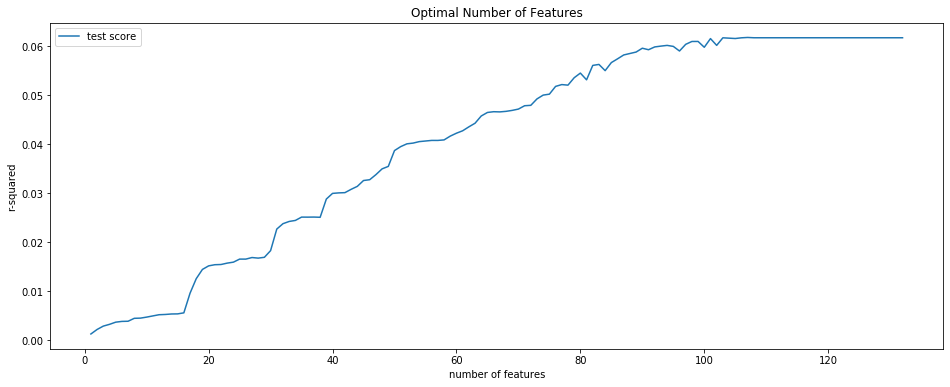

In [95]:
# plotting cv results
plt.figure(figsize=(16,6))

#plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

#### 4.1.1.2 Linear Regression - Regularisation

**Lasso Regularisation**

In [96]:
start_time = time.time()
alpha = [0.0001, 0.001, 0.005, 0.01]

for i in range(4):
    #build lasso regressor model here
    lasso = linear_model.Lasso(alpha=alpha[i])
    lasso.fit(x_train, y_train) #fit a lasso regression on the training data
    y_predlasso = lasso.predict(x_test) #use this model to predict the test data
    lasso_mse = metrics.mean_squared_error(y_test, y_predlasso) #calculate the test MSE
    lasso_rmse = metrics.mean_squared_error(y_test, y_predlasso,squared = False) #calculate the test RMSE
    msemanual = np.mean((y_predlasso-y_test)**2) #calculate mse manually to cross validate
    lasso_cplxy = (np.sum(abs(lasso.coef_))) #calculate l1norm / model complexity
    
    print('-' * 32)
    print('lasso with alpha', alpha[i])
    print('-' * 32)
    print('\nTrain score:', round(lasso.score(x_train, y_train), 3)) #compute train R^2 score
    print('Test score:', round(lasso.score(x_test, y_test), 3)) #compute test R^2 score
    print(list(map(lambda x: round(x, 3), lasso.coef_))) #list out the coef values 
    print('-' * 32)
    print('MSE on test set:', lasso_mse) #compute MSE results
    print('Manual MSE on test set:',msemanual) #compute MSE results
    print('RMSE on test set:', lasso_rmse) #compute RMSE results
    print('model complexity:', lasso_cplxy) #compute L1 NOMR score
    print('regularized cost:', lasso_mse + alpha[i] * lasso_cplxy) #compute regularised cost function scores
    print('\n')
print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))   

--------------------------------
lasso with alpha 0.0001
--------------------------------

Train score: 0.06
Test score: 0.063
[-0.16, -0.112, 0.015, -0.078, -0.03, -0.0, 0.02, 0.02, 0.022, -0.016, -0.083, -0.034, -0.016, -0.0, -0.106, 0.001, 0.027, 0.008, -0.028, -0.036, 0.036, -0.0, -0.016, -0.038, 0.003, 0.0, 0.219, 0.052, -0.044, -0.027, 0.001, -0.0, -0.017, 0.025, 0.029, 0.003, -0.032, 0.0, -0.0, -0.004, 0.0, 0.0, 0.073, 0.048, -0.001, -0.019, 0.002, -0.0, -0.0, 0.0, -0.013, 0.023, 0.059, -0.0, -0.013, 0.015, 0.028, 0.018, 0.01, 0.018, 0.028, -0.0, 0.008, 0.0, -0.001, 0.001, 0.041, -0.017, 0.0, -0.0, -0.0, -0.026, 0.0, 0.0, 0.002, 0.003, -0.017, -0.022, 0.001, -0.0, -0.0, -0.022, -0.069, 0.078, 0.017, -0.004, 0.031, -0.002, 0.0, 0.021, -0.098, -0.028, 0.0, -0.0, 0.034, -0.118, 0.035, 0.021, 0.0, 0.0, -0.011, -0.0, 0.009, -0.023, -0.0, 0.0, 0.005, -0.018]
--------------------------------
MSE on test set: 0.2658752545549907
Manual MSE on test set: 0.26587525455499134
RMSE on test se

**Ridge Regularisation**

In [97]:
start_time = time.time()
ridgealpha = [0.001, 0.01, 0.1, 1]

for i in range(4):
    #build ridge regressor here
    ridge = linear_model.Ridge(alpha=ridgealpha[i])
    ridge.fit(x_train, y_train) #fit a ridge regression on the training data
    y_pred_ridge = ridge.predict(x_test) #use this model to predict the test data
    ridge_mse = metrics.mean_squared_error(y_test, y_pred_ridge) #calculate the test mse
    ridge_rmse = metrics.mean_squared_error(y_test, y_pred_ridge,squared = False) #calculate the test rmse
    ridge_cplxy = (np.linalg.norm(ridge.coef_)) #calculate l2norm / model complexity
    
    print('-' * 32)
    print('ridge with alpha', ridgealpha[i])
    print('-' * 32)
    print('\nTrain score:', round(ridge.score(x_train, y_train), 3))
    print('Test score:', round(ridge.score(x_test, y_test), 3))
    print(list(map(lambda x: round(x, 3), ridge.coef_)))
    print('-' * 32)
    print('MSE on test set:', ridge_mse)
    print('RMSE on test set:', ridge_rmse)
    print('model complexity:', ridge_cplxy)
    print('regularized cost:', ridge_mse + ridgealpha[i] * ridge_cplxy)
    print('\n')
print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))

--------------------------------
ridge with alpha 0.001
--------------------------------

Train score: 0.06
Test score: 0.063
[-0.268, -0.329, 0.103, -0.105, -0.06, -0.03, -0.009, -0.01, -0.079, -0.12, -0.186, -0.18, -0.26, -0.099, -0.212, 0.246, 0.272, 0.101, 0.063, -0.038, 0.035, -0.092, -0.109, -0.133, -0.089, 0.055, 0.26, 0.094, -0.041, -0.023, 0.007, 0.005, -0.013, 0.031, 0.034, 0.005, -0.01, 0.001, 0.005, 0.305, 0.31, 0.324, 0.034, 0.035, -0.022, -0.046, 0.002, -0.002, -0.001, 0.001, 0.003, 0.045, 0.081, 0.019, 0.005, 0.035, 0.048, 0.038, 0.031, 0.04, 0.049, -0.01, 0.005, 0.006, -0.001, -0.005, 0.037, -0.026, 0.005, -0.01, -0.001, -0.007, 0.007, 0.005, 0.01, 0.01, -0.01, -0.016, 0.007, -0.007, 0.006, -0.041, -0.088, 0.103, 0.024, -0.022, 0.031, -0.033, -0.008, 0.028, -0.081, -0.009, 0.017, 0.019, 0.054, -0.096, 0.055, 0.042, 0.045, -0.03, -0.015, -0.042, 0.018, 0.024, 0.041, -0.044, 0.026, -0.023]
--------------------------------
MSE on test set: 0.26572144478489984
RMSE on test 

### 4.1.1.3. Principal Component Regression

In [98]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn import model_selection


In [99]:
pca = PCA()
x_reduced = pca.fit_transform(scale(x_train))


In [100]:
pd.DataFrame(pca.components_.T).loc[:4,:5]
#pd.DataFrame(pca.components_.T)

,0,1,2,3,4,5
0,-0.291743,-0.161402,-0.027861,-0.023580,-0.001745,0.015239
1,0.196274,0.112288,-0.024570,0.107384,-0.045591,0.169695
2,-0.001670,-0.076682,-0.367672,0.018829,-0.021746,0.011879
3,0.061279,0.042074,0.070762,-0.033488,0.014805,-0.061526
4,-0.059389,0.016075,0.056249,0.005534,0.024538,0.038260


In [101]:
# 10-fold CV, with shuffle
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=100) 

pcascores = model_selection.cross_val_score(LRmodel, x_reduced, y_train, scoring='neg_mean_squared_error', cv=kf_10)

print('\nR2 score:',pcascores)


R2 score: [-324088703544059166720.000000 0.061209 0.045157 0.032611 0.054609
 0.034198 0.069471 0.055578 0.034906 0.044506]


In [102]:
#specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1,109))}]
   

# GridSearchCV()
pcamodel_cv = model_selection.GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = kf_10, 
                        verbose = 10,
                        return_train_score=True)      

# fit the model
pcamodel_cv.fit(x_reduced, y_train)              

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV 1/10; 1/108] START n_features_to_select=1...................................
[CV 1/10; 1/108] END n_features_to_select=1;, score=(train=0.000, test=-0.000) total time=   2.4s
[CV 2/10; 1/108] START n_features_to_select=1...................................
[CV 2/10; 1/108] END n_features_to_select=1;, score=(train=0.000, test=0.000) total time=   2.5s
[CV 3/10; 1/108] START n_features_to_select=1...................................
[CV 3/10; 1/108] END n_features_to_select=1;, score=(train=0.000, test=0.000) total time=   3.4s
[CV 4/10; 1/108] START n_features_to_select=1...................................
[CV 4/10; 1/108] END n_features_to_select=1;, score=(train=0.000, test=-0.002) total time=   2.7s
[CV 5/10; 1/108] START n_features_to_select=1...................................
[CV 5/10; 1/108] END n_features_to_select=1;, score=(train=0.000, test=-0.001) total time=   2.6s
[CV 6/10; 1/108] START n_features_to_selec

[CV 6/10; 5/108] END n_features_to_select=5;, score=(train=0.001, test=-0.001) total time=   2.4s
[CV 7/10; 5/108] START n_features_to_select=5...................................
[CV 7/10; 5/108] END n_features_to_select=5;, score=(train=0.001, test=-0.000) total time=   2.3s
[CV 8/10; 5/108] START n_features_to_select=5...................................
[CV 8/10; 5/108] END n_features_to_select=5;, score=(train=0.001, test=-0.001) total time=   2.4s
[CV 9/10; 5/108] START n_features_to_select=5...................................
[CV 9/10; 5/108] END n_features_to_select=5;, score=(train=0.001, test=-0.002) total time=   2.3s
[CV 10/10; 5/108] START n_features_to_select=5..................................
[CV 10/10; 5/108] END n_features_to_select=5;, score=(train=0.001, test=-0.005) total time=   2.4s
[CV 1/10; 6/108] START n_features_to_select=6...................................
[CV 1/10; 6/108] END n_features_to_select=6;, score=(train=0.001, test=-0.001) total time=   2.4s
[CV 2/

[CV 2/10; 10/108] END n_features_to_select=10;, score=(train=0.001, test=0.002) total time=   2.6s
[CV 3/10; 10/108] START n_features_to_select=10.................................
[CV 3/10; 10/108] END n_features_to_select=10;, score=(train=0.001, test=0.001) total time=   2.4s
[CV 4/10; 10/108] START n_features_to_select=10.................................
[CV 4/10; 10/108] END n_features_to_select=10;, score=(train=0.001, test=-0.010) total time=   2.5s
[CV 5/10; 10/108] START n_features_to_select=10.................................
[CV 5/10; 10/108] END n_features_to_select=10;, score=(train=0.001, test=-0.001) total time=   2.8s
[CV 6/10; 10/108] START n_features_to_select=10.................................
[CV 6/10; 10/108] END n_features_to_select=10;, score=(train=0.001, test=-0.001) total time=   2.7s
[CV 7/10; 10/108] START n_features_to_select=10.................................
[CV 7/10; 10/108] END n_features_to_select=10;, score=(train=0.001, test=0.000) total time=   2.7

[CV 8/10; 14/108] END n_features_to_select=14;, score=(train=0.001, test=-0.004) total time=   3.1s
[CV 9/10; 14/108] START n_features_to_select=14.................................
[CV 9/10; 14/108] END n_features_to_select=14;, score=(train=0.002, test=-0.003) total time=   2.8s
[CV 10/10; 14/108] START n_features_to_select=14................................
[CV 10/10; 14/108] END n_features_to_select=14;, score=(train=0.001, test=-0.003) total time=   2.9s
[CV 1/10; 15/108] START n_features_to_select=15.................................
[CV 1/10; 15/108] END n_features_to_select=15;, score=(train=0.001, test=-0.001) total time=   2.6s
[CV 2/10; 15/108] START n_features_to_select=15.................................
[CV 2/10; 15/108] END n_features_to_select=15;, score=(train=0.001, test=0.002) total time=   2.9s
[CV 3/10; 15/108] START n_features_to_select=15.................................
[CV 3/10; 15/108] END n_features_to_select=15;, score=(train=0.001, test=-0.001) total time=   

[CV 4/10; 19/108] END n_features_to_select=19;, score=(train=0.002, test=-0.025) total time=   2.6s
[CV 5/10; 19/108] START n_features_to_select=19.................................
[CV 5/10; 19/108] END n_features_to_select=19;, score=(train=0.001, test=-0.001) total time=   2.5s
[CV 6/10; 19/108] START n_features_to_select=19.................................
[CV 6/10; 19/108] END n_features_to_select=19;, score=(train=0.001, test=-0.001) total time=   2.5s
[CV 7/10; 19/108] START n_features_to_select=19.................................
[CV 7/10; 19/108] END n_features_to_select=19;, score=(train=0.001, test=0.001) total time=   2.6s
[CV 8/10; 19/108] START n_features_to_select=19.................................
[CV 8/10; 19/108] END n_features_to_select=19;, score=(train=0.001, test=-0.003) total time=   2.5s
[CV 9/10; 19/108] START n_features_to_select=19.................................
[CV 9/10; 19/108] END n_features_to_select=19;, score=(train=0.002, test=-0.004) total time=   2

[CV 10/10; 23/108] END n_features_to_select=23;, score=(train=0.001, test=-0.002) total time=   2.8s
[CV 1/10; 24/108] START n_features_to_select=24.................................
[CV 1/10; 24/108] END n_features_to_select=24;, score=(train=0.002, test=-0.918) total time=   2.8s
[CV 2/10; 24/108] START n_features_to_select=24.................................
[CV 2/10; 24/108] END n_features_to_select=24;, score=(train=0.002, test=0.001) total time=   2.9s
[CV 3/10; 24/108] START n_features_to_select=24.................................
[CV 3/10; 24/108] END n_features_to_select=24;, score=(train=0.002, test=-0.002) total time=   2.7s
[CV 4/10; 24/108] START n_features_to_select=24.................................
[CV 4/10; 24/108] END n_features_to_select=24;, score=(train=0.003, test=-0.025) total time=   2.6s
[CV 5/10; 24/108] START n_features_to_select=24.................................
[CV 5/10; 24/108] END n_features_to_select=24;, score=(train=0.002, test=-0.001) total time=   

[CV 6/10; 28/108] END n_features_to_select=28;, score=(train=0.017, test=0.015) total time=   2.4s
[CV 7/10; 28/108] START n_features_to_select=28.................................
[CV 7/10; 28/108] END n_features_to_select=28;, score=(train=0.015, test=0.021) total time=   2.2s
[CV 8/10; 28/108] START n_features_to_select=28.................................
[CV 8/10; 28/108] END n_features_to_select=28;, score=(train=0.003, test=-0.008) total time=   2.2s
[CV 9/10; 28/108] START n_features_to_select=28.................................
[CV 9/10; 28/108] END n_features_to_select=28;, score=(train=0.017, test=0.005) total time=   2.1s
[CV 10/10; 28/108] START n_features_to_select=28................................
[CV 10/10; 28/108] END n_features_to_select=28;, score=(train=0.017, test=-0.005) total time=   2.3s
[CV 1/10; 29/108] START n_features_to_select=29.................................
[CV 1/10; 29/108] END n_features_to_select=29;, score=(train=0.009, test=-2.261) total time=   2.

[CV 2/10; 33/108] END n_features_to_select=33;, score=(train=0.023, test=0.030) total time=   2.3s
[CV 3/10; 33/108] START n_features_to_select=33.................................
[CV 3/10; 33/108] END n_features_to_select=33;, score=(train=0.025, test=0.017) total time=   2.1s
[CV 4/10; 33/108] START n_features_to_select=33.................................
[CV 4/10; 33/108] END n_features_to_select=33;, score=(train=0.024, test=0.008) total time=   2.2s
[CV 5/10; 33/108] START n_features_to_select=33.................................
[CV 5/10; 33/108] END n_features_to_select=33;, score=(train=0.025, test=0.021) total time=   2.1s
[CV 6/10; 33/108] START n_features_to_select=33.................................
[CV 6/10; 33/108] END n_features_to_select=33;, score=(train=0.026, test=0.018) total time=   2.1s
[CV 7/10; 33/108] START n_features_to_select=33.................................
[CV 7/10; 33/108] END n_features_to_select=33;, score=(train=0.024, test=0.033) total time=   2.1s
[

[CV 8/10; 37/108] END n_features_to_select=37;, score=(train=0.032, test=0.033) total time=   2.1s
[CV 9/10; 37/108] START n_features_to_select=37.................................
[CV 9/10; 37/108] END n_features_to_select=37;, score=(train=0.034, test=0.017) total time=   2.1s
[CV 10/10; 37/108] START n_features_to_select=37................................
[CV 10/10; 37/108] END n_features_to_select=37;, score=(train=0.043, test=0.028) total time=   2.2s
[CV 1/10; 38/108] START n_features_to_select=38.................................
[CV 1/10; 38/108] END n_features_to_select=38;, score=(train=0.016, test=-13.011) total time=   2.1s
[CV 2/10; 38/108] START n_features_to_select=38.................................
[CV 2/10; 38/108] END n_features_to_select=38;, score=(train=0.025, test=0.028) total time=   2.2s
[CV 3/10; 38/108] START n_features_to_select=38.................................
[CV 3/10; 38/108] END n_features_to_select=38;, score=(train=0.042, test=0.040) total time=   2.2

[CV 4/10; 42/108] END n_features_to_select=42;, score=(train=0.041, test=0.019) total time=   2.4s
[CV 5/10; 42/108] START n_features_to_select=42.................................
[CV 5/10; 42/108] END n_features_to_select=42;, score=(train=0.043, test=0.041) total time=   2.4s
[CV 6/10; 42/108] START n_features_to_select=42.................................
[CV 6/10; 42/108] END n_features_to_select=42;, score=(train=0.047, test=0.029) total time=   2.3s
[CV 7/10; 42/108] START n_features_to_select=42.................................
[CV 7/10; 42/108] END n_features_to_select=42;, score=(train=0.043, test=0.052) total time=   2.3s
[CV 8/10; 42/108] START n_features_to_select=42.................................
[CV 8/10; 42/108] END n_features_to_select=42;, score=(train=0.046, test=0.053) total time=   2.5s
[CV 9/10; 42/108] START n_features_to_select=42.................................
[CV 9/10; 42/108] END n_features_to_select=42;, score=(train=0.044, test=0.025) total time=   2.6s
[

[CV 10/10; 46/108] END n_features_to_select=46;, score=(train=0.046, test=0.028) total time=   2.0s
[CV 1/10; 47/108] START n_features_to_select=47.................................
[CV 1/10; 47/108] END n_features_to_select=47;, score=(train=0.022, test=-23.851) total time=   2.0s
[CV 2/10; 47/108] START n_features_to_select=47.................................
[CV 2/10; 47/108] END n_features_to_select=47;, score=(train=0.045, test=0.050) total time=   2.1s
[CV 3/10; 47/108] START n_features_to_select=47.................................
[CV 3/10; 47/108] END n_features_to_select=47;, score=(train=0.046, test=0.038) total time=   2.2s
[CV 4/10; 47/108] START n_features_to_select=47.................................
[CV 4/10; 47/108] END n_features_to_select=47;, score=(train=0.039, test=0.006) total time=   1.9s
[CV 5/10; 47/108] START n_features_to_select=47.................................
[CV 5/10; 47/108] END n_features_to_select=47;, score=(train=0.046, test=0.040) total time=   2.1

[CV 6/10; 51/108] END n_features_to_select=51;, score=(train=0.049, test=0.029) total time=   2.2s
[CV 7/10; 51/108] START n_features_to_select=51.................................
[CV 7/10; 51/108] END n_features_to_select=51;, score=(train=0.049, test=0.057) total time=   2.0s
[CV 8/10; 51/108] START n_features_to_select=51.................................
[CV 8/10; 51/108] END n_features_to_select=51;, score=(train=0.051, test=0.052) total time=   1.8s
[CV 9/10; 51/108] START n_features_to_select=51.................................
[CV 9/10; 51/108] END n_features_to_select=51;, score=(train=0.054, test=0.033) total time=   2.0s
[CV 10/10; 51/108] START n_features_to_select=51................................
[CV 10/10; 51/108] END n_features_to_select=51;, score=(train=0.050, test=0.042) total time=   1.9s
[CV 1/10; 52/108] START n_features_to_select=52.................................
[CV 1/10; 52/108] END n_features_to_select=52;, score=(train=0.024, test=-29.878) total time=   2.0

[CV 2/10; 56/108] END n_features_to_select=56;, score=(train=0.053, test=0.059) total time=   2.0s
[CV 3/10; 56/108] START n_features_to_select=56.................................
[CV 3/10; 56/108] END n_features_to_select=56;, score=(train=0.054, test=0.041) total time=   1.7s
[CV 4/10; 56/108] START n_features_to_select=56.................................
[CV 4/10; 56/108] END n_features_to_select=56;, score=(train=0.001, test=-0.045) total time=   1.8s
[CV 5/10; 56/108] START n_features_to_select=56.................................
[CV 5/10; 56/108] END n_features_to_select=56;, score=(train=0.054, test=0.049) total time=   1.8s
[CV 6/10; 56/108] START n_features_to_select=56.................................
[CV 6/10; 56/108] END n_features_to_select=56;, score=(train=0.055, test=0.032) total time=   1.9s
[CV 7/10; 56/108] START n_features_to_select=56.................................
[CV 7/10; 56/108] END n_features_to_select=56;, score=(train=0.053, test=0.061) total time=   1.8s


[CV 8/10; 60/108] END n_features_to_select=60;, score=(train=0.055, test=0.053) total time=   1.8s
[CV 9/10; 60/108] START n_features_to_select=60.................................
[CV 9/10; 60/108] END n_features_to_select=60;, score=(train=0.057, test=0.035) total time=   1.7s
[CV 10/10; 60/108] START n_features_to_select=60................................
[CV 10/10; 60/108] END n_features_to_select=60;, score=(train=0.050, test=0.033) total time=   1.7s
[CV 1/10; 61/108] START n_features_to_select=61.................................
[CV 1/10; 61/108] END n_features_to_select=61;, score=(train=0.026, test=-52.160) total time=   1.8s
[CV 2/10; 61/108] START n_features_to_select=61.................................
[CV 2/10; 61/108] END n_features_to_select=61;, score=(train=0.055, test=0.059) total time=   1.7s
[CV 3/10; 61/108] START n_features_to_select=61.................................
[CV 3/10; 61/108] END n_features_to_select=61;, score=(train=0.053, test=0.038) total time=   1.8

[CV 4/10; 65/108] END n_features_to_select=65;, score=(train=0.059, test=0.036) total time=   1.6s
[CV 5/10; 65/108] START n_features_to_select=65.................................
[CV 5/10; 65/108] END n_features_to_select=65;, score=(train=0.058, test=0.054) total time=   1.7s
[CV 6/10; 65/108] START n_features_to_select=65.................................
[CV 6/10; 65/108] END n_features_to_select=65;, score=(train=0.058, test=0.031) total time=   1.5s
[CV 7/10; 65/108] START n_features_to_select=65.................................
[CV 7/10; 65/108] END n_features_to_select=65;, score=(train=0.055, test=0.068) total time=   1.5s
[CV 8/10; 65/108] START n_features_to_select=65.................................
[CV 8/10; 65/108] END n_features_to_select=65;, score=(train=0.058, test=0.054) total time=   1.7s
[CV 9/10; 65/108] START n_features_to_select=65.................................
[CV 9/10; 65/108] END n_features_to_select=65;, score=(train=0.058, test=0.031) total time=   1.5s
[

[CV 10/10; 69/108] END n_features_to_select=69;, score=(train=0.054, test=0.044) total time=   1.6s
[CV 1/10; 70/108] START n_features_to_select=70.................................
[CV 1/10; 70/108] END n_features_to_select=70;, score=(train=0.029, test=-131.685) total time=   1.6s
[CV 2/10; 70/108] START n_features_to_select=70.................................
[CV 2/10; 70/108] END n_features_to_select=70;, score=(train=0.058, test=0.059) total time=   1.5s
[CV 3/10; 70/108] START n_features_to_select=70.................................
[CV 3/10; 70/108] END n_features_to_select=70;, score=(train=0.056, test=0.043) total time=   1.5s
[CV 4/10; 70/108] START n_features_to_select=70.................................
[CV 4/10; 70/108] END n_features_to_select=70;, score=(train=0.060, test=0.032) total time=   1.3s
[CV 5/10; 70/108] START n_features_to_select=70.................................
[CV 5/10; 70/108] END n_features_to_select=70;, score=(train=0.059, test=0.057) total time=   1.

[CV 6/10; 74/108] END n_features_to_select=74;, score=(train=0.056, test=0.037) total time=   1.3s
[CV 7/10; 74/108] START n_features_to_select=74.................................
[CV 7/10; 74/108] END n_features_to_select=74;, score=(train=0.056, test=0.065) total time=   1.4s
[CV 8/10; 74/108] START n_features_to_select=74.................................
[CV 8/10; 74/108] END n_features_to_select=74;, score=(train=0.059, test=0.054) total time=   1.3s
[CV 9/10; 74/108] START n_features_to_select=74.................................
[CV 9/10; 74/108] END n_features_to_select=74;, score=(train=0.061, test=0.034) total time=   1.3s
[CV 10/10; 74/108] START n_features_to_select=74................................
[CV 10/10; 74/108] END n_features_to_select=74;, score=(train=0.049, test=0.030) total time=   1.4s
[CV 1/10; 75/108] START n_features_to_select=75.................................
[CV 1/10; 75/108] END n_features_to_select=75;, score=(train=0.032, test=-245.898) total time=   1.

[CV 2/10; 79/108] END n_features_to_select=79;, score=(train=0.059, test=0.060) total time=   1.3s
[CV 3/10; 79/108] START n_features_to_select=79.................................
[CV 3/10; 79/108] END n_features_to_select=79;, score=(train=0.060, test=0.047) total time=   1.4s
[CV 4/10; 79/108] START n_features_to_select=79.................................
[CV 4/10; 79/108] END n_features_to_select=79;, score=(train=0.062, test=0.035) total time=   1.3s
[CV 5/10; 79/108] START n_features_to_select=79.................................
[CV 5/10; 79/108] END n_features_to_select=79;, score=(train=0.057, test=0.045) total time=   1.3s
[CV 6/10; 79/108] START n_features_to_select=79.................................
[CV 6/10; 79/108] END n_features_to_select=79;, score=(train=0.034, test=0.004) total time=   1.4s
[CV 7/10; 79/108] START n_features_to_select=79.................................
[CV 7/10; 79/108] END n_features_to_select=79;, score=(train=0.056, test=0.065) total time=   1.3s
[

[CV 8/10; 83/108] END n_features_to_select=83;, score=(train=0.060, test=0.055) total time=   1.1s
[CV 9/10; 83/108] START n_features_to_select=83.................................
[CV 9/10; 83/108] END n_features_to_select=83;, score=(train=0.059, test=0.033) total time=   1.0s
[CV 10/10; 83/108] START n_features_to_select=83................................
[CV 10/10; 83/108] END n_features_to_select=83;, score=(train=0.058, test=0.043) total time=   1.0s
[CV 1/10; 84/108] START n_features_to_select=84.................................
[CV 1/10; 84/108] END n_features_to_select=84;, score=(train=0.037, test=-788.515) total time=   1.0s
[CV 2/10; 84/108] START n_features_to_select=84.................................
[CV 2/10; 84/108] END n_features_to_select=84;, score=(train=0.059, test=0.060) total time=   1.0s
[CV 3/10; 84/108] START n_features_to_select=84.................................
[CV 3/10; 84/108] END n_features_to_select=84;, score=(train=0.044, test=0.033) total time=   1.

[CV 4/10; 88/108] END n_features_to_select=88;, score=(train=0.062, test=0.034) total time=   0.9s
[CV 5/10; 88/108] START n_features_to_select=88.................................
[CV 5/10; 88/108] END n_features_to_select=88;, score=(train=0.060, test=0.057) total time=   0.9s
[CV 6/10; 88/108] START n_features_to_select=88.................................
[CV 6/10; 88/108] END n_features_to_select=88;, score=(train=0.057, test=0.030) total time=   0.8s
[CV 7/10; 88/108] START n_features_to_select=88.................................
[CV 7/10; 88/108] END n_features_to_select=88;, score=(train=0.056, test=0.063) total time=   0.9s
[CV 8/10; 88/108] START n_features_to_select=88.................................
[CV 8/10; 88/108] END n_features_to_select=88;, score=(train=0.060, test=0.055) total time=   0.8s
[CV 9/10; 88/108] START n_features_to_select=88.................................
[CV 9/10; 88/108] END n_features_to_select=88;, score=(train=0.062, test=0.035) total time=   0.8s
[

[CV 10/10; 92/108] END n_features_to_select=92;, score=(train=0.054, test=0.034) total time=   0.7s
[CV 1/10; 93/108] START n_features_to_select=93.................................
[CV 1/10; 93/108] END n_features_to_select=93;, score=(train=0.042, test=-2384.050) total time=   0.6s
[CV 2/10; 93/108] START n_features_to_select=93.................................
[CV 2/10; 93/108] END n_features_to_select=93;, score=(train=0.059, test=0.061) total time=   0.7s
[CV 3/10; 93/108] START n_features_to_select=93.................................
[CV 3/10; 93/108] END n_features_to_select=93;, score=(train=0.061, test=0.045) total time=   0.6s
[CV 4/10; 93/108] START n_features_to_select=93.................................
[CV 4/10; 93/108] END n_features_to_select=93;, score=(train=0.063, test=0.033) total time=   0.7s
[CV 5/10; 93/108] START n_features_to_select=93.................................
[CV 5/10; 93/108] END n_features_to_select=93;, score=(train=0.059, test=0.054) total time=   0

[CV 6/10; 97/108] END n_features_to_select=97;, score=(train=0.050, test=0.023) total time=   0.6s
[CV 7/10; 97/108] START n_features_to_select=97.................................
[CV 7/10; 97/108] END n_features_to_select=97;, score=(train=0.059, test=0.070) total time=   0.5s
[CV 8/10; 97/108] START n_features_to_select=97.................................
[CV 8/10; 97/108] END n_features_to_select=97;, score=(train=0.060, test=0.055) total time=   0.6s
[CV 9/10; 97/108] START n_features_to_select=97.................................
[CV 9/10; 97/108] END n_features_to_select=97;, score=(train=0.063, test=0.035) total time=   0.6s
[CV 10/10; 97/108] START n_features_to_select=97................................
[CV 10/10; 97/108] END n_features_to_select=97;, score=(train=0.061, test=0.045) total time=   0.6s
[CV 1/10; 98/108] START n_features_to_select=98.................................
[CV 1/10; 98/108] END n_features_to_select=98;, score=(train=0.044, test=-4661.731) total time=   0

[CV 2/10; 102/108] END n_features_to_select=102;, score=(train=0.060, test=0.061) total time=   0.4s
[CV 3/10; 102/108] START n_features_to_select=102...............................
[CV 3/10; 102/108] END n_features_to_select=102;, score=(train=0.061, test=0.046) total time=   0.3s
[CV 4/10; 102/108] START n_features_to_select=102...............................
[CV 4/10; 102/108] END n_features_to_select=102;, score=(train=0.063, test=0.034) total time=   0.2s
[CV 5/10; 102/108] START n_features_to_select=102...............................
[CV 5/10; 102/108] END n_features_to_select=102;, score=(train=0.060, test=0.054) total time=   0.3s
[CV 6/10; 102/108] START n_features_to_select=102...............................
[CV 6/10; 102/108] END n_features_to_select=102;, score=(train=0.063, test=0.034) total time=   0.3s
[CV 7/10; 102/108] START n_features_to_select=102...............................
[CV 7/10; 102/108] END n_features_to_select=102;, score=(train=0.050, test=0.055) total ti

[CV 7/10; 106/108] END n_features_to_select=106;, score=(train=0.059, test=0.069) total time=   0.1s
[CV 8/10; 106/108] START n_features_to_select=106...............................
[CV 8/10; 106/108] END n_features_to_select=106;, score=(train=0.060, test=0.056) total time=   0.1s
[CV 9/10; 106/108] START n_features_to_select=106...............................
[CV 9/10; 106/108] END n_features_to_select=106;, score=(train=0.063, test=0.036) total time=   0.1s
[CV 10/10; 106/108] START n_features_to_select=106..............................
[CV 10/10; 106/108] END n_features_to_select=106;, score=(train=0.061, test=0.045) total time=   0.1s
[CV 1/10; 107/108] START n_features_to_select=107...............................
[CV 1/10; 107/108] END n_features_to_select=107;, score=(train=0.061, test=-7991930.696) total time=   0.1s
[CV 2/10; 107/108] START n_features_to_select=107...............................
[CV 2/10; 107/108] END n_features_to_select=107;, score=(train=0.060, test=0.061) 

GridSearchCV(cv=KFold(n_splits=10, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, 30, ...]}],
             return_train_score=True, scoring='r2', verbose=10)

In [103]:
pcacv_results = pd.DataFrame(pcamodel_cv.cv_results_)
pcacv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,2.838549,0.256134,0.001154,0.000502,1,{'n_features_to_select': 1},-1.320827e-05,0.000182,0.000307,-0.002223,...,0.000112,0.000288,0.000261,0.000095,0.000146,0.000151,0.000182,0.000163,0.000164,0.000061
1,2.524249,0.113746,0.000951,0.000270,2,{'n_features_to_select': 2},-6.966761e-04,0.000564,0.000391,-0.005089,...,0.000304,0.000575,0.000481,0.000389,0.000306,0.000264,0.000365,0.000315,0.000357,0.000096
2,2.493251,0.083826,0.000900,0.000200,3,{'n_features_to_select': 3},-1.628036e-04,0.000384,0.000123,-0.007335,...,0.000445,0.000814,0.000659,0.000508,0.000417,0.000406,0.000545,0.000434,0.000505,0.000130
3,2.505900,0.072390,0.001100,0.000374,4,{'n_features_to_select': 4},-7.381615e-04,0.000611,0.000249,-0.010241,...,0.000510,0.000976,0.000786,0.000613,0.000520,0.000505,0.000695,0.000544,0.000619,0.000152
4,2.556051,0.183405,0.001100,0.000490,5,{'n_features_to_select': 5},-7.212898e-04,0.000589,0.000028,-0.010641,...,0.000596,0.001081,0.000849,0.000692,0.000623,0.000595,0.000827,0.000548,0.000703,0.000164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,0.322354,0.024310,0.003400,0.001115,104,{'n_features_to_select': 104},-3.501088e+05,0.061555,0.046603,0.033388,...,0.061305,0.062768,0.060435,0.062368,0.058665,0.060341,0.063137,0.061305,0.059807,0.004050
104,0.248446,0.035851,0.003701,0.001077,105,{'n_features_to_select': 105},-1.706232e+06,0.061341,0.046763,0.032769,...,0.061339,0.062789,0.060418,0.062369,0.058666,0.060323,0.063114,0.061272,0.060780,0.001675
105,0.205399,0.029159,0.003099,0.000799,106,{'n_features_to_select': 106},-1.811557e+06,0.061303,0.045134,0.033129,...,0.061435,0.062785,0.060432,0.061640,0.058743,0.060338,0.063133,0.061125,0.060726,0.001589
106,0.135606,0.021349,0.003097,0.000998,107,{'n_features_to_select': 107},-7.991931e+06,0.061098,0.045251,0.033066,...,0.061434,0.062781,0.060436,0.061639,0.058744,0.060322,0.063152,0.061103,0.061087,0.001249


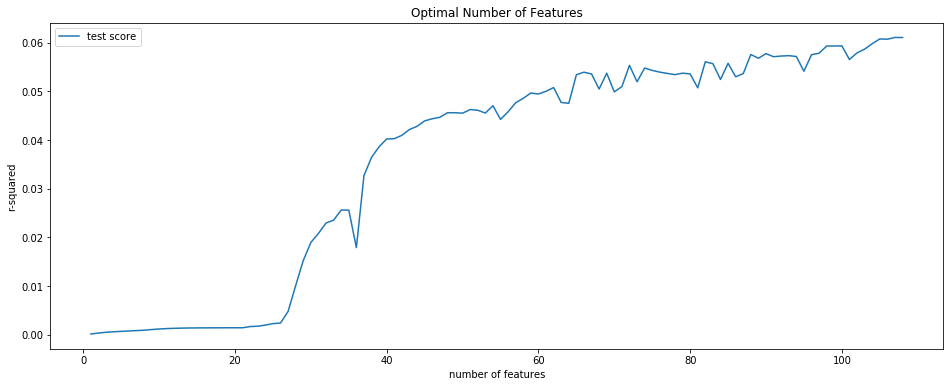

In [104]:
# plotting cv results
plt.figure(figsize=(16,6))

#plt.plot(cv_results["param_n_features_to_select"], pcacv_results["mean_test_score"])
plt.plot(pcacv_results["param_n_features_to_select"], pcacv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

Text(0, 0.5, 'cumulative explained variance')

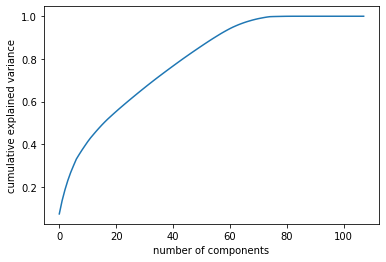

In [105]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

### 4.1.2. Ensemble Models

In [106]:
def evaluate_model(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions-test_labels)
    mse = metrics.mean_squared_error(test_labels,predictions)
    rmse = np.sqrt(mse)
    
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    rsquare = model.score(test_features,test_labels)
    importance = model.feature_importances_

    
    print('Model Preformance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%,'.format(accuracy))
    print('rmse',rmse)
    print('mse',mse)
    print('R square:', rsquare)
    
    print("__________")
    print("Top 5 Features")
    feature_dict = {}
    for i,v in enumerate(importance):
        #print('Feature %0d, Score: %.5f' % (i,v))
        feature_dict[i]=v
    feature_names = test_features.columns
    sorted_features = sorted(feature_dict.items(), key=lambda x: x[1], reverse=True)
    
    for i in sorted_features[:5]:
        print(feature_names[i[0]],i[1])
        
    plt.bar([x for x in range(len(importance))],importance)
    plt.show()
    
    
    
    return accuracy

### 4.1.2.1. Random Forest

In [107]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_features': [27, 30, 33],
    'oob_score': [True],
    'n_estimators': [2250, 2500, 2750]
}
# Create a based model
rfgs = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfgs, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 3)
#wrapper_gs = RegressorChain(grid_search)
grid_search.fit(x_train, y_train)

#grid_search.fit(train_features, train_labels)
print(grid_search.best_params_)

print(grid_search.best_estimator_)
print(grid_search.best_score_)

y_pred_rfgs = grid_search.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfgs))
print("RMSE: %f" % (rmse))

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred_rfgs))
# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred_rfgs))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'bootstrap': True, 'max_features': 15, 'n_estimators': 1500, 'oob_score': True}
RandomForestRegressor(max_features=15, n_estimators=1500, oob_score=True)
0.03671855190637082
RMSE: 0.513187
Mean squared error: 0.26
R2 score: 0.07


Model Preformance
Average Error: 0.4272 degrees.
Accuracy = -inf%,
rmse 0.5131866924391295
mse 0.2633605812966137
R square: 0.07161926611042724
__________
Top 5 Features
WRKCOUNT 0.02692824547502773
R_SEX_2 0.02113656786461498
R_SEX_1 0.021121807530204418
HHFAMINC_6 0.020429895998478925
HHFAMINC_7 0.01954777552321755


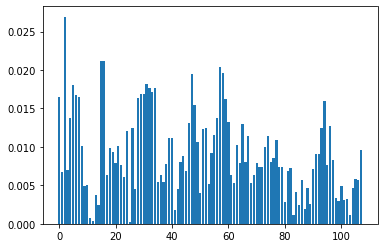

In [108]:
best_rf = grid_search.best_estimator_
rf_accuracy = evaluate_model(best_rf, x_test, y_test)


### 4.1.2.2.Adaboost

In [109]:
from sklearn import tree, ensemble, model_selection, metrics
from sklearn.model_selection import GridSearchCV

ada2=ensemble.AdaBoostRegressor(tree.DecisionTreeRegressor(), random_state = 888)

parameters ={
    'n_estimators':[350, 400, 500],
    'learning_rate':[0.01, 0.1],
    'base_estimator__max_depth':[25, 30, 35]
}

grid_ADA = GridSearchCV(estimator=ada2, param_grid=parameters, scoring='neg_mean_squared_error',n_jobs=-1, cv=3, verbose=3)
grid_ADA.fit(x_train, y_train)

 

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_ADA.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_ADA.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_ADA.best_params_)

#print("\n The best accuracy across ALL searched params:\n",evaluate(best_grid, x_test, y_test_one))

 

y_pred_ADA = grid_ADA.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ADA))
print("RMSE: %f" % (rmse))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_ADA))
# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred_ADA))

### Gradient Boosting Regressor

In [ ]:
GBR = ensemble.GradientBoostingRegressor(random_state = 888)

parameters = {
    'learning_rate': [0.1, 0.2],
    'n_estimators' : [180, 200, 225],
    'max_depth'    : [5, 6, 8]
}

 

grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 3, n_jobs=-1, verbose = 3)
grid_GBR.fit(x_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

#print("\n The best accuracy across ALL searched params:\n",evaluate(best_grid, x_test, y_test_one))


y_pred_GBR = grid_GBR.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_GBR))

print("RMSE: %f" % (rmse))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_GBR))

# Explained variance score: 1 is perfect prediction
print('R2 score: %.4f' % r2_score(y_test, y_pred_GBR))

## SVM???

### 4.1.3. Neural Network

In [110]:
train_df = pd.concat([y_train,x_train], axis = 1)
test_df = pd.concat([y_test, x_train],axis =1)
test_df.rename(columns = {'HHSIZE_ above_3':'HHSIZE_above_3'} , inplace = True)

In [111]:
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
from keras.layers import Dropout

In [146]:
def create_model_deep(input_shape,learn_rate,dropout_rate, layers,kernel_reg): #name,my_feature_layer,dropout_rate, layers):
    model = tf.keras.models.Sequential()#name = name)
    model.add(tf.keras.Input(shape=(input_shape,)))
    #model.add(my_feature_layer)
    for index, layer in enumerate(layers):
        model.add(tf.keras.layers.Dense(units = layer,
                                        activation = 'relu',
                                        kernel_regularizer=kernel_reg,
                                        name=f'Hidden{index}'))
    model.add(Dropout(dropout_rate))  
    model.add(tf.keras.layers.Dense(units=1, name='Output'))  
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learn_rate),
                  loss="mean_squared_error",
                  metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [113]:
one_hot_labs = [c for c in train_df if train_df[c].dtype == 'uint8']
num_labs = ['tier diff','bay diff','quantity','pos diff']

In [114]:
feature_columns = []
for i in num_labs:
    i = tf.feature_column.numeric_column(i)
    feature_columns.append(i)
for k in one_hot_labs:
    k = tf.feature_column.numeric_column(k)
    feature_columns.append(k)
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [148]:
import time
start_time = time.time()

input_shape = [x_train.shape[1]]
learn_rate = ((0.01),(0.1),(0.3))
batch_size = ((128,),(256,))
dropout_rate = ((0.1),(0),(0.2))
name = ['deep']
kernel_reg = ((tf.keras.regularizers.l2(0.04)),('glorot_uniform'))
layers = ((64,32,16,8),(64,16,8,4),(64,16),(64,32,16,8,4),(30,20,10,8))

 
param_grid = dict(input_shape = input_shape,
                  learn_rate = learn_rate,
                  dropout_rate = dropout_rate,
                  layers = layers,
                  kernel_reg = kernel_reg)

    
model_deep = KerasRegressor(build_fn = create_model_deep, epochs = 1000, batch_size = 256, verbose =2)
nn_grid = GridSearchCV(estimator = model_deep, param_grid = param_grid, n_jobs = -1, scoring='neg_mean_squared_error',verbose =5, cv = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 888))
nn_grid_result = nn_grid.fit(x_train, y_train)
best_nn = nn_grid.best_estimator_

print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))

Fitting 5 folds for each of 90 candidates, totalling 450 fits


KeyboardInterrupt: 

In [116]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



predictions = best_nn.predict(x_test)
mse = metrics.mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
rsquare = r2_score(y_test, predictions)

print('Model Preformance')
print('rmse',rmse)
print('mse',mse)
print('R square:', rsquare)

17/17 - 0s
Model Preformance
rmse 0.532929017599013
mse 0.2840133377990491
R square: -0.0011844205467608226


In [117]:
nn_grid_result.best_params_

{'learn_rate': 0.01,
 'layers': (64, 32, 16, 8),
 'kernel_reg': <tensorflow.python.keras.regularizers.L2 at 0x148215bf948>,
 'input_shape': 108,
 'dropout_rate': 0.2}

In [118]:
# Create a table to compare the best results from X_train

| X_Train | Linear - Lasso | Ensemble - Random Forest | Nerual Network | 
|---|---|---|---|
| Parameters | 0 | 0 | 0 |
| MSE  | 0 | 0.0180 | 0.0420 |
| RMSE | 1.362 | 0.647 | 0 | 
| R-Square| 0.0172 | 0.0245 | 0.0420 | 
| Top Features| - | - | NA |

Overall best model is ___ for x_train dataset. However as model is week explore using trip distances

## 4.2. X_train_dist
X_train now to include the distances columns obtained from the trips data. Should there be improvement, would suggest that obtaining binned distance measures for different WHY categories would prove to aid the model better

In [119]:
# run models with x_train_dist here - probably for each (linear vs ensemble vs nn) choose the best (E.G. run L2_linear, xgboost , NN )

### 4.2.1. Linear Models

#### 4.2.1.1. Linear Regression

In [90]:
LRmodel_with_dist = linear_model.LinearRegression()  #create the linear regression 
LRmodel_with_dist.fit(x_train_with_dist,y_train) #train the model using the training set 
LR_pred_with_dist = LRmodel_with_dist.predict(x_test_with_dist) #use this model to predict the test data set 

In [91]:
print('R^2 score:\t\t\t\t',LRmodel_with_dist.score(x_test_with_dist, y_test)) #compute R^2 score 
print('Explained Variance: \t\t\t', metrics.explained_variance_score(y_test, LR_pred_with_dist)) #compute explained variance score
print('Mean Absolute Error: \t\t\t', metrics.mean_absolute_error(y_test, LR_pred_with_dist)) #compute MAE results
print('Mean Squared Error:\t\t\t', metrics.mean_squared_error(y_test, LR_pred_with_dist)) #compute MSE results
print('Root Mean Squared Error:\t\t', metrics.mean_squared_error(y_test, LR_pred_with_dist, squared = False)) #compute RSME results
print('Intercept:\t', LRmodel_with_dist.intercept_) #find intercept value 
print('Coef:\t', np.sum(LRmodel_with_dist.coef_!=0))#find no of features used in regression model 

R^2 score:				 0.549369558731999
Explained Variance: 			 0.5496560251745507
Mean Absolute Error: 			 1.177828663930843
Mean Squared Error:			 2.4550791718821525
Root Mean Squared Error:		 1.5668692261583774
Intercept:	 -765070596794.1272
Coef:	 132


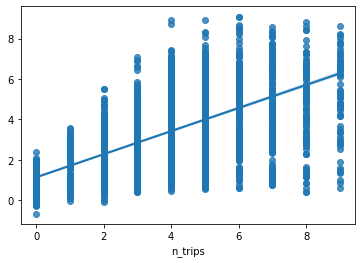

In [92]:
sns.regplot(y_test,LR_pred_with_dist) #plotting predictions 

In [95]:
#calculate VIF scores to detect multicolinearity 

# VIF dataframe
vif_data_with_dist = pd.DataFrame()
vif_data_with_dist["feature"] = x_train_with_dist.columns
  
# calculating VIF for each feature
vif_data_with_dist["VIF"] = [variance_inflation_factor(x_train_with_dist.values, i)
                          for i in range(len(x_train_with_dist.columns))]
  
print(vif_data_with_dist)

                                feature        VIF
0                               NUMADLT  29.462559
1                            YOUNGCHILD  20.534203
2                              WRKCOUNT  59.928189
3                                EDUC_1   6.462240
4                                EDUC_2  20.975975
..                                  ...        ...
127  dist_to_relatvies_between_5_and_11   1.019836
128      dist_to_social_between_1_and_2   1.024989
129      dist_to_social_greater_than_11   1.060397
130      dist_to_social_between_2_and_5   1.041867
131     dist_to_social_between_5_and_11   1.039295

[132 rows x 2 columns]


In [96]:
vif_data_with_dist.sort_values(by = 'VIF', ascending = False)

,feature,VIF
66,MSASIZE_2,inf
91,AGE_bins_26_to_35,inf
84,LIF_CYC_4,inf
85,LIF_CYC_5,inf
86,LIF_CYC_6,inf
...,...,...
121,dist_to_school_or_church_greater_than_11,1.020442
127,dist_to_relatvies_between_5_and_11,1.019836
123,dist_to_school_or_church_between_5_and_11,1.019044
126,dist_to_relatvies_between_2_and_5,1.014627


In [97]:
# counting number of infinity features 

vif_data_inf_with_dist = np.isinf(vif_data_with_dist['VIF']).values.sum()
print("It contains " + str(vif_data_inf_with_dist) + " infinite values")


It contains 66 infinite values


In [98]:
#cross validation to see if it will improve results 
folds = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 100)
scores_with_dist = model_selection.cross_val_score(LRmodel, x_train_with_dist, y_train, scoring='neg_mean_squared_error', cv=folds)
print('\nR2 score:',scores)

NameError: name 'scores' is not defined

In [ ]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
scores_with_dist

In [ ]:
from sklearn.feature_selection import RFE
import time
start_time = time.time()
#specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1,109))}]


# perform grid search

rfe_with_dist = RFE(LRmodel_with_dist)             

# 3.2 call GridSearchCV()
model_cv_with_dist = model_selection.GridSearchCV(estimator = rfe_with_dist, 
                        param_grid = hyper_params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = folds, 
                        verbose = 10,
                        return_train_score=True)      

# fit the model
model_cv_with_dist.fit(x_train_with_dist, y_train)
print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))

In [ ]:
# cv results
cv_results_with_dist = pd.DataFrame(model_cv_with_dist.cv_results_)
cv_results_with_dist


In [ ]:
# plotting cv results
plt.figure(figsize=(16,6))

#plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results_with_dist["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')


#### 4.1.1.2 Linear Regression – Regularisation

**Lasso Regularisation**

In [131]:
alpha = [0.0001, 0.001, 0.005, 0.01]

for i in range(4):
    #build lasso regressor model here
    lasso_with_dist = linear_model.Lasso(alpha=alpha[i])
    lasso_with_dist.fit(x_train_with_dist, y_train) #fit a lasso regression on the training data
    y_predlasso_with_dist = lasso_with_dist.predict(x_test_with_dist) #use this model to predict the test data
    lasso_mse_with_dist = metrics.mean_squared_error(y_test, y_predlasso_with_dist) #calculate the test MSE
    lasso_rmse_with_dist = metrics.mean_squared_error(y_test, y_predlasso_with_dist,squared = False) #calculate the test RMSE
    msemanual_with_dist = np.mean((y_predlasso_with_dist-y_test)**2) #calculate mse manually to cross validate
    lasso_cplxy_with_dist = (np.sum(abs(lasso_with_dist.coef_))) #calculate l1norm / model complexity
    
    print('-' * 32)
    print('lasso with alpha', alpha[i])
    print('-' * 32)
    print('\nTrain score:', round(lasso_with_dist.score(x_train_with_dist, y_train), 3)) #compute train R^2 score
    print('Test score:', round(lasso_with_dist.score(x_test_with_dist, y_test), 3)) #compute test R^2 score
    print(list(map(lambda x: round(x, 3), lasso_with_dist.coef_))) #list out the coef values 
    print('-' * 32)
    print('MSE on test set:', lasso_mse_with_dist) #compute MSE results
    print('Manual MSE on test set:',msemanual_with_dist) #compute MSE results
    print('RMSE on test set:', lasso_rmse_with_dist) #compute RMSE results
    print('model complexity:', lasso_cplxy_with_dist) #compute L1 NOMR score
    print('regularized cost:', lasso_mse_with_dist + alpha[i] * lasso_cplxy_with_dist) #compute regularised cost function scores
    print('\n')


--------------------------------
lasso with alpha 0.0001
--------------------------------

Train score: 0.343
Test score: 0.319
[-0.05, -0.038, -0.0, -0.057, -0.012, -0.007, 0.0, -0.0, 0.026, -0.005, -0.055, -0.0, -0.0, 0.0, -0.07, 0.0, 0.016, 0.004, 0.0, 0.004, 0.035, 0.025, 0.0, -0.026, 0.011, 0.0, 0.154, 0.014, -0.052, -0.004, 0.011, 0.013, -0.0, 0.022, -0.015, 0.008, -0.034, -0.015, 0.003, -0.002, 0.001, 0.0, 0.022, 0.016, -0.008, -0.004, 0.016, 0.007, -0.004, -0.003, -0.0, 0.0, 0.03, 0.013, -0.01, 0.024, 0.024, 0.003, 0.0, 0.0, 0.0, -0.002, 0.0, -0.0, 0.012, -0.0, 0.028, -0.025, 0.0, -0.0, 0.0, -0.088, 0.0, 0.0, -0.019, -0.003, 0.004, 0.056, 0.051, -0.0, 0.0, -0.033, -0.051, -0.0, 0.014, -0.006, 0.005, -0.0, 0.0, 0.008, -0.073, -0.034, -0.0, 0.0, 0.026, -0.07, 0.042, 0.034, 0.0, 0.0, -0.004, 0.013, -0.0, -0.034, -0.0, 0.0, 0.019, -0.008, 0.15, 0.088, 0.14, 0.13, 0.307, 0.338, 0.326, 0.343, 0.435, 0.377, 0.414, 0.408, 0.186, 0.218, 0.196, 0.238, 0.276, 0.167, 0.283, 0.265, 0.337, 0

**Ridge Regularisation**

In [132]:
ridgealpha = [0.001, 0.01, 0.1, 1]

for i in range(4):
    #build ridge regressor here
    ridge_with_dist = linear_model.Ridge(alpha=ridgealpha[i])
    ridge_with_dist.fit(x_train_with_dist, y_train) #fit a ridge regression on the training data
    y_pred_ridge_with_dist = ridge_with_dist.predict(x_test_with_dist) #use this model to predict the test data
    ridge_mse_with_dist = metrics.mean_squared_error(y_test, y_pred_ridge_with_dist) #calculate the test mse
    ridge_rmse_with_dist = metrics.mean_squared_error(y_test, y_pred_ridge_with_dist,squared = False) #calculate the test rmse
    ridge_cplxy_with_dist = (np.linalg.norm(ridge_with_dist.coef_)) #calculate l2norm / model complexity
    
    print('-' * 32)
    print('ridge with alpha', ridgealpha[i])
    print('-' * 32)
    print('\nTrain score:', round(ridge_with_dist.score(x_train_with_dist, y_train), 3))
    print('Test score:', round(ridge_with_dist.score(x_test_with_dist, y_test), 3))
    print(list(map(lambda x: round(x, 3), ridge_with_dist.coef_)))
    print('-' * 32)
    print('MSE on test set:', ridge_mse_with_dist)
    print('RMSE on test set:', ridge_rmse_with_dist)
    print('model complexity:', ridge_cplxy_with_dist)
    print('regularized cost:', ridge_mse_with_dist + ridgealpha_with_dist[i] * ridge_cplxy_with_dist)
    print('\n')


--------------------------------
ridge with alpha 0.001
--------------------------------

Train score: 0.344
Test score: 0.32
[-0.121, -0.157, -0.002, -0.116, -0.078, -0.074, -0.066, -0.067, -0.045, -0.08, -0.13, -0.09, -0.205, -0.067, -0.146, 0.226, 0.242, -0.339, -0.344, 0.098, 0.129, 0.278, 0.251, 0.222, 0.263, 0.411, 0.224, 0.083, -0.05, -0.002, 0.015, 0.018, 0.004, 0.026, -0.012, 0.014, -0.01, -0.012, 0.009, 0.012, 0.017, 0.015, 0.017, 0.012, -0.013, -0.017, 0.013, 0.002, -0.009, -0.007, 0.016, 0.018, 0.049, 0.035, 0.006, 0.042, 0.043, 0.021, 0.019, 0.019, 0.018, -0.01, 0.002, 0.002, 0.007, -0.001, 0.029, -0.026, 0.002, -0.01, 0.007, -0.036, 0.036, -0.009, -0.027, -0.013, -0.001, 0.05, 0.036, -0.036, 0.004, -0.029, -0.047, -0.004, 0.035, -0.009, 0.022, -0.001, 0.014, 0.013, -0.068, -0.025, 0.005, 0.01, 0.036, -0.058, 0.054, 0.045, 0.026, -0.017, -0.008, -0.002, 0.008, -0.006, -0.004, -0.003, 0.017, -0.01, 0.156, 0.092, 0.144, 0.134, 0.31, 0.341, 0.329, 0.346, 0.437, 0.379, 0.415, 

### 4.2.1.3. Principal Component Regression

In [133]:
pca_with_dist = PCA()
x_reduced_with_dist = pca_with_dist.fit_transform(scale(x_train_with_dist))

In [134]:
pd.DataFrame(pca.components_.T).loc[:4,:5]
#pd.DataFrame(pca.components_.T)

,0,1,2,3,4,5
0,-0.291503,-0.161232,-0.021334,-0.025692,-0.001232,0.017427
1,0.195335,0.109423,-0.029828,0.106641,-0.045100,0.192536
2,-0.000240,-0.087936,-0.351604,0.017036,-0.017801,-0.011451
3,0.061854,0.044987,0.068238,-0.031656,0.014140,-0.075522
4,-0.059461,0.017201,0.049305,0.006209,0.023079,0.041639


In [135]:
# 10-fold CV, with shuffle
kf_5 = model_selection.KFold(n_splits=5, shuffle=True, random_state=100)

pcascores_with_dist = model_selection_with_dist.cross_val_score(LRmodel, x_reduced_with_dist, y_train, scoring='neg_mean_squared_error', cv=kf_10)

print('\nR2 score:',pcascores_with_dist)



R2 score: [-618001394367471943680.000000 0.327006 0.332160 0.304231 0.307615
 0.358326 0.346009 0.341804 0.346984 0.361538]


In [136]:
#specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1,133))}]
   

# GridSearchCV()
pcamodel_cv_with_dist = model_selection.GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = kf_5, 
                        verbose = 10,
                        return_train_score=True)      

# fit the model
pcamodel_cv_with_dist.fit(x_reduced_with_dist, y_train)  


Fitting 5 folds for each of 132 candidates, totalling 660 fits
[CV 1/5; 1/132] START n_features_to_select=1....................................
[CV 1/5; 1/132] END n_features_to_select=1;, score=(train=0.000, test=0.000) total time=   3.5s
[CV 2/5; 1/132] START n_features_to_select=1....................................
[CV 2/5; 1/132] END n_features_to_select=1;, score=(train=0.000, test=-0.000) total time=   3.5s
[CV 3/5; 1/132] START n_features_to_select=1....................................
[CV 3/5; 1/132] END n_features_to_select=1;, score=(train=0.000, test=-0.000) total time=   3.7s
[CV 4/5; 1/132] START n_features_to_select=1....................................
[CV 4/5; 1/132] END n_features_to_select=1;, score=(train=0.000, test=0.000) total time=   3.8s
[CV 5/5; 1/132] START n_features_to_select=1....................................
[CV 5/5; 1/132] END n_features_to_select=1;, score=(train=0.000, test=-0.002) total time=   3.9s
[CV 1/5; 2/132] START n_features_to_select=2.....

[CV 2/5; 10/132] END n_features_to_select=10;, score=(train=0.002, test=-0.017) total time=   3.7s
[CV 3/5; 10/132] START n_features_to_select=10..................................
[CV 3/5; 10/132] END n_features_to_select=10;, score=(train=0.001, test=-0.002) total time=   3.7s
[CV 4/5; 10/132] START n_features_to_select=10..................................
[CV 4/5; 10/132] END n_features_to_select=10;, score=(train=0.001, test=-0.003) total time=   3.3s
[CV 5/5; 10/132] START n_features_to_select=10..................................
[CV 5/5; 10/132] END n_features_to_select=10;, score=(train=0.001, test=-0.004) total time=   3.2s
[CV 1/5; 11/132] START n_features_to_select=11..................................
[CV 1/5; 11/132] END n_features_to_select=11;, score=(train=0.001, test=-0.010) total time=   3.1s
[CV 2/5; 11/132] START n_features_to_select=11..................................
[CV 2/5; 11/132] END n_features_to_select=11;, score=(train=0.002, test=-0.018) total time=   3.7s
[

[CV 3/5; 19/132] END n_features_to_select=19;, score=(train=0.001, test=-0.001) total time=   3.1s
[CV 4/5; 19/132] START n_features_to_select=19..................................
[CV 4/5; 19/132] END n_features_to_select=19;, score=(train=0.002, test=-0.023) total time=   3.1s
[CV 5/5; 19/132] START n_features_to_select=19..................................
[CV 5/5; 19/132] END n_features_to_select=19;, score=(train=0.001, test=-0.004) total time=   3.1s
[CV 1/5; 20/132] START n_features_to_select=20..................................
[CV 1/5; 20/132] END n_features_to_select=20;, score=(train=0.001, test=-0.028) total time=   3.3s
[CV 2/5; 20/132] START n_features_to_select=20..................................
[CV 2/5; 20/132] END n_features_to_select=20;, score=(train=0.002, test=-0.084) total time=   3.3s
[CV 3/5; 20/132] START n_features_to_select=20..................................
[CV 3/5; 20/132] END n_features_to_select=20;, score=(train=0.001, test=-0.001) total time=   3.1s
[

[CV 4/5; 28/132] END n_features_to_select=28;, score=(train=0.189, test=0.185) total time=   3.1s
[CV 5/5; 28/132] START n_features_to_select=28..................................
[CV 5/5; 28/132] END n_features_to_select=28;, score=(train=0.175, test=0.193) total time=   3.1s
[CV 1/5; 29/132] START n_features_to_select=29..................................
[CV 1/5; 29/132] END n_features_to_select=29;, score=(train=0.074, test=-8.543) total time=   3.0s
[CV 2/5; 29/132] START n_features_to_select=29..................................
[CV 2/5; 29/132] END n_features_to_select=29;, score=(train=0.178, test=0.155) total time=   3.0s
[CV 3/5; 29/132] START n_features_to_select=29..................................
[CV 3/5; 29/132] END n_features_to_select=29;, score=(train=0.184, test=0.184) total time=   3.5s
[CV 4/5; 29/132] START n_features_to_select=29..................................
[CV 4/5; 29/132] END n_features_to_select=29;, score=(train=0.194, test=0.186) total time=   3.0s
[CV 5/

[CV 5/5; 37/132] END n_features_to_select=37;, score=(train=0.242, test=0.251) total time=   3.3s
[CV 1/5; 38/132] START n_features_to_select=38..................................
[CV 1/5; 38/132] END n_features_to_select=38;, score=(train=0.135, test=-36.954) total time=   2.9s
[CV 2/5; 38/132] START n_features_to_select=38..................................
[CV 2/5; 38/132] END n_features_to_select=38;, score=(train=0.207, test=0.202) total time=   3.0s
[CV 3/5; 38/132] START n_features_to_select=38..................................
[CV 3/5; 38/132] END n_features_to_select=38;, score=(train=0.246, test=0.241) total time=   3.0s
[CV 4/5; 38/132] START n_features_to_select=38..................................
[CV 4/5; 38/132] END n_features_to_select=38;, score=(train=0.254, test=0.261) total time=   2.9s
[CV 5/5; 38/132] START n_features_to_select=38..................................
[CV 5/5; 38/132] END n_features_to_select=38;, score=(train=0.244, test=0.252) total time=   3.1s
[CV 1

[CV 1/5; 47/132] END n_features_to_select=47;, score=(train=0.155, test=-71.479) total time=   2.8s
[CV 2/5; 47/132] START n_features_to_select=47..................................
[CV 2/5; 47/132] END n_features_to_select=47;, score=(train=0.252, test=0.240) total time=   2.7s
[CV 3/5; 47/132] START n_features_to_select=47..................................
[CV 3/5; 47/132] END n_features_to_select=47;, score=(train=0.273, test=0.266) total time=   2.9s
[CV 4/5; 47/132] START n_features_to_select=47..................................
[CV 4/5; 47/132] END n_features_to_select=47;, score=(train=0.273, test=0.280) total time=   3.2s
[CV 5/5; 47/132] START n_features_to_select=47..................................
[CV 5/5; 47/132] END n_features_to_select=47;, score=(train=0.203, test=0.219) total time=   3.1s
[CV 1/5; 48/132] START n_features_to_select=48..................................
[CV 1/5; 48/132] END n_features_to_select=48;, score=(train=0.155, test=-77.364) total time=   3.0s
[CV

[CV 2/5; 56/132] END n_features_to_select=56;, score=(train=0.255, test=0.236) total time=   2.7s
[CV 3/5; 56/132] START n_features_to_select=56..................................
[CV 3/5; 56/132] END n_features_to_select=56;, score=(train=0.296, test=0.288) total time=   2.7s
[CV 4/5; 56/132] START n_features_to_select=56..................................
[CV 4/5; 56/132] END n_features_to_select=56;, score=(train=0.264, test=0.272) total time=   2.9s
[CV 5/5; 56/132] START n_features_to_select=56..................................
[CV 5/5; 56/132] END n_features_to_select=56;, score=(train=0.216, test=0.236) total time=   2.6s
[CV 1/5; 57/132] START n_features_to_select=57..................................
[CV 1/5; 57/132] END n_features_to_select=57;, score=(train=0.180, test=-108.656) total time=   2.6s
[CV 2/5; 57/132] START n_features_to_select=57..................................
[CV 2/5; 57/132] END n_features_to_select=57;, score=(train=0.306, test=0.284) total time=   2.7s
[CV 

[CV 3/5; 65/132] END n_features_to_select=65;, score=(train=0.315, test=0.307) total time=   2.7s
[CV 4/5; 65/132] START n_features_to_select=65..................................
[CV 4/5; 65/132] END n_features_to_select=65;, score=(train=0.313, test=0.322) total time=   2.5s
[CV 5/5; 65/132] START n_features_to_select=65..................................
[CV 5/5; 65/132] END n_features_to_select=65;, score=(train=0.307, test=0.315) total time=   2.5s
[CV 1/5; 66/132] START n_features_to_select=66..................................
[CV 1/5; 66/132] END n_features_to_select=66;, score=(train=0.196, test=-203.284) total time=   2.4s
[CV 2/5; 66/132] START n_features_to_select=66..................................
[CV 2/5; 66/132] END n_features_to_select=66;, score=(train=0.319, test=0.292) total time=   2.5s
[CV 3/5; 66/132] START n_features_to_select=66..................................
[CV 3/5; 66/132] END n_features_to_select=66;, score=(train=0.315, test=0.306) total time=   2.4s
[CV 

[CV 4/5; 74/132] END n_features_to_select=74;, score=(train=0.321, test=0.325) total time=   2.6s
[CV 5/5; 74/132] START n_features_to_select=74..................................
[CV 5/5; 74/132] END n_features_to_select=74;, score=(train=0.320, test=0.330) total time=   2.3s
[CV 1/5; 75/132] START n_features_to_select=75..................................
[CV 1/5; 75/132] END n_features_to_select=75;, score=(train=0.211, test=-318.123) total time=   2.2s
[CV 2/5; 75/132] START n_features_to_select=75..................................
[CV 2/5; 75/132] END n_features_to_select=75;, score=(train=0.329, test=0.299) total time=   2.6s
[CV 3/5; 75/132] START n_features_to_select=75..................................
[CV 3/5; 75/132] END n_features_to_select=75;, score=(train=0.326, test=0.317) total time=   2.2s
[CV 4/5; 75/132] START n_features_to_select=75..................................
[CV 4/5; 75/132] END n_features_to_select=75;, score=(train=0.322, test=0.326) total time=   2.2s
[CV 

[CV 5/5; 83/132] END n_features_to_select=83;, score=(train=0.324, test=0.335) total time=   3.3s
[CV 1/5; 84/132] START n_features_to_select=84..................................
[CV 1/5; 84/132] END n_features_to_select=84;, score=(train=0.240, test=-810.935) total time=   2.4s
[CV 2/5; 84/132] START n_features_to_select=84..................................
[CV 2/5; 84/132] END n_features_to_select=84;, score=(train=0.337, test=0.301) total time=   2.1s
[CV 3/5; 84/132] START n_features_to_select=84..................................
[CV 3/5; 84/132] END n_features_to_select=84;, score=(train=0.331, test=0.322) total time=   2.2s
[CV 4/5; 84/132] START n_features_to_select=84..................................
[CV 4/5; 84/132] END n_features_to_select=84;, score=(train=0.329, test=0.331) total time=   2.0s
[CV 5/5; 84/132] START n_features_to_select=84..................................
[CV 5/5; 84/132] END n_features_to_select=84;, score=(train=0.322, test=0.333) total time=   2.1s
[CV 

[CV 1/5; 93/132] END n_features_to_select=93;, score=(train=0.263, test=-1504.329) total time=   2.0s
[CV 2/5; 93/132] START n_features_to_select=93..................................
[CV 2/5; 93/132] END n_features_to_select=93;, score=(train=0.341, test=0.304) total time=   2.6s
[CV 3/5; 93/132] START n_features_to_select=93..................................
[CV 3/5; 93/132] END n_features_to_select=93;, score=(train=0.337, test=0.324) total time=   2.7s
[CV 4/5; 93/132] START n_features_to_select=93..................................
[CV 4/5; 93/132] END n_features_to_select=93;, score=(train=0.334, test=0.337) total time=   1.8s
[CV 5/5; 93/132] START n_features_to_select=93..................................
[CV 5/5; 93/132] END n_features_to_select=93;, score=(train=0.331, test=0.343) total time=   1.9s
[CV 1/5; 94/132] START n_features_to_select=94..................................
[CV 1/5; 94/132] END n_features_to_select=94;, score=(train=0.268, test=-1698.900) total time=   2.5s

[CV 2/5; 102/132] END n_features_to_select=102;, score=(train=0.344, test=0.309) total time=   1.9s
[CV 3/5; 102/132] START n_features_to_select=102................................
[CV 3/5; 102/132] END n_features_to_select=102;, score=(train=0.342, test=0.327) total time=   1.6s
[CV 4/5; 102/132] START n_features_to_select=102................................
[CV 4/5; 102/132] END n_features_to_select=102;, score=(train=0.340, test=0.341) total time=   1.7s
[CV 5/5; 102/132] START n_features_to_select=102................................
[CV 5/5; 102/132] END n_features_to_select=102;, score=(train=0.335, test=0.347) total time=   1.9s
[CV 1/5; 103/132] START n_features_to_select=103................................
[CV 1/5; 103/132] END n_features_to_select=103;, score=(train=0.297, test=-3412.350) total time=   2.2s
[CV 2/5; 103/132] START n_features_to_select=103................................
[CV 2/5; 103/132] END n_features_to_select=103;, score=(train=0.345, test=0.309) total time

[CV 3/5; 111/132] END n_features_to_select=111;, score=(train=0.344, test=0.331) total time=   1.0s
[CV 4/5; 111/132] START n_features_to_select=111................................
[CV 4/5; 111/132] END n_features_to_select=111;, score=(train=0.341, test=0.343) total time=   1.0s
[CV 5/5; 111/132] START n_features_to_select=111................................
[CV 5/5; 111/132] END n_features_to_select=111;, score=(train=0.338, test=0.353) total time=   1.0s
[CV 1/5; 112/132] START n_features_to_select=112................................
[CV 1/5; 112/132] END n_features_to_select=112;, score=(train=0.319, test=-10022.974) total time=   1.1s
[CV 2/5; 112/132] START n_features_to_select=112................................
[CV 2/5; 112/132] END n_features_to_select=112;, score=(train=0.348, test=0.316) total time=   1.0s
[CV 3/5; 112/132] START n_features_to_select=112................................
[CV 3/5; 112/132] END n_features_to_select=112;, score=(train=0.343, test=0.330) total tim

[CV 4/5; 120/132] END n_features_to_select=120;, score=(train=0.342, test=0.345) total time=   0.6s
[CV 5/5; 120/132] START n_features_to_select=120................................
[CV 5/5; 120/132] END n_features_to_select=120;, score=(train=0.339, test=0.354) total time=   0.6s
[CV 1/5; 121/132] START n_features_to_select=121................................
[CV 1/5; 121/132] END n_features_to_select=121;, score=(train=0.337, test=-19692.628) total time=   0.5s
[CV 2/5; 121/132] START n_features_to_select=121................................
[CV 2/5; 121/132] END n_features_to_select=121;, score=(train=0.349, test=0.318) total time=   0.5s
[CV 3/5; 121/132] START n_features_to_select=121................................
[CV 3/5; 121/132] END n_features_to_select=121;, score=(train=0.345, test=0.334) total time=   0.6s
[CV 4/5; 121/132] START n_features_to_select=121................................
[CV 4/5; 121/132] END n_features_to_select=121;, score=(train=0.342, test=0.345) total tim

[CV 5/5; 129/132] END n_features_to_select=129;, score=(train=0.340, test=0.354) total time=   0.2s
[CV 1/5; 130/132] START n_features_to_select=130................................
[CV 1/5; 130/132] END n_features_to_select=130;, score=(train=0.348, test=-1612792.068) total time=   0.1s
[CV 2/5; 130/132] START n_features_to_select=130................................
[CV 2/5; 130/132] END n_features_to_select=130;, score=(train=0.349, test=0.319) total time=   0.1s
[CV 3/5; 130/132] START n_features_to_select=130................................
[CV 3/5; 130/132] END n_features_to_select=130;, score=(train=0.345, test=0.334) total time=   0.1s
[CV 4/5; 130/132] START n_features_to_select=130................................
[CV 4/5; 130/132] END n_features_to_select=130;, score=(train=0.342, test=0.344) total time=   0.1s
[CV 5/5; 130/132] START n_features_to_select=130................................
[CV 5/5; 130/132] END n_features_to_select=130;, score=(train=0.337, test=0.351) total t

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, 30, ...]}],
             return_train_score=True, scoring='r2', verbose=10)

In [137]:
pcacv_results_with_dist = pd.DataFrame(pcamodel_cv_with_dist.cv_results_)
pcacv_results_with_dist


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.782506,0.151421,0.001394,0.000587,1,{'n_features_to_select': 1},1.561358e-04,-0.000286,-0.000217,0.000130,...,-5.201530e-04,9.487001e-04,1,0.000036,0.000091,0.000026,0.000044,0.000194,0.000078,0.000062
1,3.713701,0.325332,0.002798,0.002135,2,{'n_features_to_select': 2},-2.703549e-04,-0.003047,-0.000565,-0.000068,...,-1.241076e-03,1.188780e-03,2,0.000143,0.000626,0.000267,0.000225,0.000325,0.000317,0.000165
2,3.636393,0.374877,0.001592,0.000200,3,{'n_features_to_select': 3},-8.822905e-05,-0.004043,-0.000782,-0.000144,...,-1.498425e-03,1.528753e-03,3,0.000242,0.000747,0.000463,0.000258,0.000518,0.000446,0.000186
3,3.589499,0.227088,0.001801,0.000400,4,{'n_features_to_select': 4},-3.158005e-04,-0.004771,-0.000735,-0.000316,...,-1.705871e-03,1.713045e-03,4,0.000303,0.000930,0.000603,0.000364,0.000652,0.000570,0.000224
4,3.790098,0.553048,0.002106,0.000370,5,{'n_features_to_select': 5},-5.176729e-04,-0.005831,-0.001425,-0.000913,...,-2.267854e-03,1.921327e-03,5,0.000333,0.001053,0.000816,0.000416,0.000693,0.000662,0.000263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0.278120,0.019822,0.004396,0.000378,128,{'n_features_to_select': 128},-6.990658e+04,0.318676,0.333974,0.344322,...,-1.398105e+04,2.796277e+04,128,0.339253,0.348860,0.344780,0.342455,0.339451,0.342960,0.003590
128,0.259604,0.044160,0.004895,0.000869,129,{'n_features_to_select': 129},-1.090226e+06,0.318928,0.334552,0.344454,...,-2.180450e+05,4.360906e+05,129,0.346448,0.348839,0.344815,0.342485,0.339590,0.344435,0.003190
129,0.200307,0.023882,0.005000,0.001051,130,{'n_features_to_select': 130},-1.612792e+06,0.318965,0.334175,0.344345,...,-3.225581e+05,6.451170e+05,130,0.347756,0.348815,0.345042,0.342461,0.337323,0.344279,0.004122
130,0.155208,0.048890,0.005392,0.002561,131,{'n_features_to_select': 131},-2.100164e+06,0.318829,0.333762,0.344294,...,-4.200325e+05,8.400657e+05,131,0.348582,0.348840,0.343859,0.342456,0.339549,0.344657,0.003591


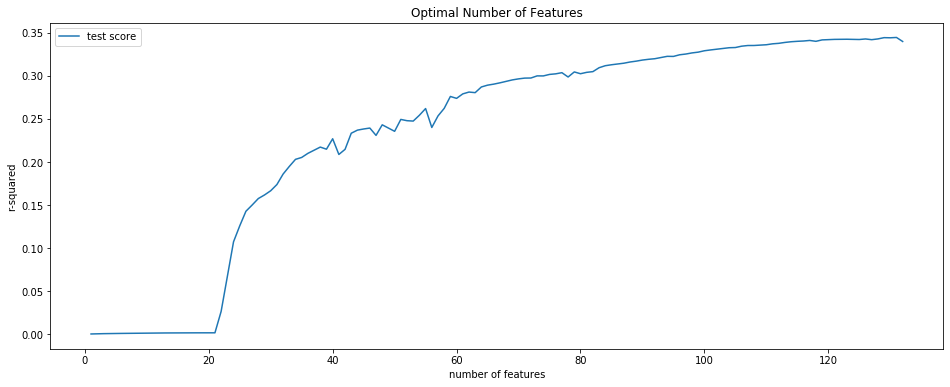

In [138]:
# plotting cv results
plt.figure(figsize=(16,6))

#plt.plot(cv_results["param_n_features_to_select"], pcacv_results["mean_test_score"])
plt.plot(pcacv_results_with_dist["param_n_features_to_select"], pcacv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')


Text(0, 0.5, 'cumulative explained variance')

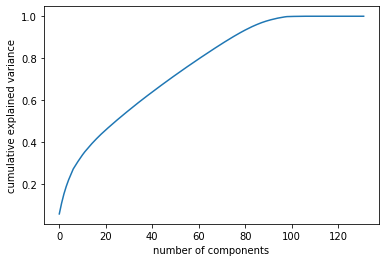

In [139]:
plt.plot(np.cumsum(pca_with_dist.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')


### 4.2.2.1. Random Forest

In [140]:

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_features': [27, 30, 33],
    'oob_score': [True],
    'n_estimators': [2250, 2500, 2750]
}
# Create a based model
rfgs = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfgs, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 3)
#wrapper_gs = RegressorChain(grid_search)
grid_search.fit(x_train_with_dist, y_train)

#grid_search.fit(train_features, train_labels)
print(grid_search.best_params_)

print(grid_search.best_estimator_)
print(grid_search.best_score_)

y_pred_rfgs = grid_search.predict(x_test_with_dist)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfgs))
print("RMSE: %f" % (rmse))

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred_rfgs))
# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred_rfgs))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'bootstrap': True, 'max_features': 19, 'n_estimators': 1500, 'oob_score': True}
RandomForestRegressor(max_features=19, n_estimators=1500, oob_score=True)
0.30675468323209115
RMSE: 0.432892
Mean squared error: 0.19
R2 score: 0.34


Model Preformance
Average Error: 0.3476 degrees.
Accuracy = -inf%,
rmse 0.43289178733053146
mse 0.18739529953822207
R square: 0.33940688900283844
__________
Top 5 Features
dist_to_family_between_2_and_5 0.03378112223926495
dist_to_family_between_5_and_11 0.031255586450679794
dist_to_social_between_2_and_5 0.023545118889107354
dist_to_family_greater_than_11 0.02286159222142778
dist_to_family_between_1_and_2 0.022299632835674297


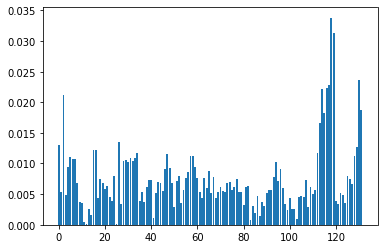

In [141]:
best_rf = grid_search.best_estimator_
rf_accuracy = evaluate_model(best_rf, x_test_with_dist, y_test)

### 4.2..2. Adaboost

In [ ]:
ada2=ensemble.AdaBoostRegressor(tree.DecisionTreeRegressor(), random_state = 888)

parameters ={
    'n_estimators':[350, 400, 500],
    'learning_rate':[0.01, 0.1],
    'base_estimator__max_depth':[25, 30, 35]
}

grid_ADA = GridSearchCV(estimator=ada2, param_grid=parameters, scoring='neg_mean_squared_error',n_jobs=-1, cv=3, verbose=3)
grid_ADA.fit(x_train_with_dist, y_train)

 
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_ADA.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_ADA.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_ADA.best_params_)
#print("\n The best accuracy across ALL searched params:\n",evaluate(best_grid, x_test, y_test_one))

 
y_pred_ADA = grid_ADA.predict(x_test_with_dist)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ADA))
print("RMSE: %f" % (rmse))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_ADA))

# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred_ADA))

### 4.2.3. Gradient Boosting Regressor

In [ ]:
GBR = ensemble.GradientBoostingRegressor(random_state = 888)

parameters = {
    'learning_rate': [0.1, 0.2],
    'n_estimators' : [180, 200, 225],
    'max_depth'    : [5, 6, 8]
}

 
grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 3, n_jobs=-1, verbose = 3)
grid_GBR.fit(x_train_with_dist, y_train)


print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)
#print("\n The best accuracy across ALL searched params:\n",evaluate(best_grid, x_test, y_test_one))
 

y_pred_GBR = grid_GBR.predict(x_test_with_dist)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_GBR))

print("RMSE: %f" % (rmse))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_GBR))

# Explained variance score: 1 is perfect prediction
print('R2 score: %.4f' % r2_score(y_test, y_pred_GBR))

### 4.2.3. Neural Network

In [143]:
#use the same param_grid as earlier

start_time = time.time()

input_shape = [x_train_with_dist.shape[1]]
learn_rate = ((0.01),(0.1),(0.3))
batch_size = ((128,),(256,))
dropout_rate = ((0.1),(0),(0.2))
name = ['deep']
kernel_reg = ((tf.keras.regularizers.l2(0.04)),('glorot_uniform'))
layers = ((64,32,16,8),(64,16,8,4),(64,16),(64,32,16,8,4),(30,20,10,8))

 
param_grid = dict(input_shape = input_shape,
                  learn_rate = learn_rate,
                  dropout_rate = dropout_rate,
                  layers = layers,
                  kernel_reg = kernel_reg)

    
model_deep = KerasRegressor(build_fn = create_model_deep, epochs = 1000, batch_size = 256, verbose =2)
nn_grid = GridSearchCV(estimator = model_deep, param_grid = param_grid, n_jobs = -1, scoring='neg_mean_squared_error',verbose =5, cv = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 888))
nn_grid_result = nn_grid.fit(x_train_with_dist, y_train)
best_nn = nn_grid.best_estimator_

print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



predictions = best_nn.predict(x_test_with_dist)
mse = metrics.mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
rsquare = r2_score(y_test, predictions)

print('Model Preformance')
print('rmse',rmse)
print('mse',mse)
print('R square:', rsquare)

In [ ]:
nn_grid_result.best_params_

| X_Train_with_dist | Linear - Lasso | Ensemble - Random Forest | Nerual Network | 
|---|---|---|---|
| MSE  | 0 | 0.0180 | 2.49 |
| RMSE | 1.362 | 0.647 | 1.58 | 
| R-Square| 0.0172 | 0.0245 | 0.55 | 
|Top Features | - | - | NA|

Overall, adding distance features improved all models significantly and hence reccommendation is for future surveys to add in questions regarding main why column to ask distance bins.

e.g. select from bins the distance to workplace for each member of the family 
